In [1]:
## main imports
%matplotlib inline

import os
import gc

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from glob import glob
from pprint import pprint
#from process import process_one_file
#print (glob('*.xy'))  #['file1.txt','file2.txt','file3.txt']

In [2]:
# from functions.array_process_functions import *

from diffpy.pdfgetx.functs import loadData
from diffpy.pdfgetx.pdfgetter import PDFGetter
from diffpy.srfit.pdf.characteristicfunctions import lognormalSphericalCF, sphericalCF

from numpy import pi

from pyobjcryst.crystal import CreateCrystalFromCIF

from diffpy.srfit.pdf import PDFParser, PDFGenerator
from diffpy.srfit.fitbase import Profile
from diffpy.srfit.fitbase import FitContribution, FitRecipe
from diffpy.srfit.fitbase import FitResults

import cPickle as pickle

# from gaussianrecipe import scipyOptimize

from scipy.optimize.minpack import leastsq
from scipy.optimize import fmin


In [3]:
import seaborn as sns
# usage ex: sns.set_style("whitegrid")
# sns.set()
sns.set_style("ticks", {'grid.linestyle': '--',
                            'axes.linewidth': 2,
                            'grid.linewidth': 0.01,
                            'axes.edgecolor': '0.8'})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})
#Annotation formatting
bbox_props = dict(boxstyle="round", fc="w", ec="0.8", alpha=1)
bbox_props_alt = dict(boxstyle="round", fc="w", ec="0.1", alpha=1)



In [4]:
#Annotation formatting

bbox_props = dict(boxstyle="round", fc="w", ec="0.8", alpha=1)
bbox_props_alt = dict(boxstyle="round4", fc="white", ec="0.1", alpha=1)
bbox_props_alt2 = dict(boxstyle="round4", fc="red", ec="0.1", alpha=0.2)
bbox_props_alt3 = dict(boxstyle="round4", fc="blue", ec="0", alpha=0.2)

from diffpy.srfit.pdf.characteristicfunctions import lognormalSphericalCF, sphericalCF, spheroidalCF, spheroidalCF2

def bSeabornStyle(ticks=False, cycle='simon', context='notebook', f_scale=1, a_scale=1, 
                  l_width=1, m_size=1, xt_col='black'):
    sns.reset_orig()
    if ticks==False:
        sns.set_style("whitegrid")
    else:
        sns.set_style("ticks")
        
    sns.set_style({
    'grid.linestyle': '--',
    'grid.color': 'b2b2b2',
    'axes.linewidth': (a_scale*1.75),
    'axes.labelcolor':'black',
    'axes.edgecolor': 'black',
    'xtick.color': xt_col,
    'ytick.color': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    })
    
    sns.set_context(context, font_scale=(f_scale*1.5), 
                    rc={"lines.linewidth": (l_width*2),
                        "lines.markersize":(m_size*5),})
    mpl.rcParams['font.family']='Arial'
    mpl.rcParams['mathtext.fontset'] = 'stixsans'
    mpl.rcParams['font.size'] = 18
    mpl.rcParams['figure.dpi'] = 240
    mpl.rcParams['figure.figsize'] = 9, 6
    mpl.rcParams['grid.linewidth'] = 0.5
    mpl.rcParams['savefig.bbox'] = 'tight'
    
    
    if cycle=='simon':
        simonCycle = ["#0B3C5D", "#062F4F", "#328CC1", "#D9B310", "#984B43", "#B82601",
                 "#57652A", "#76323F", "#626E60", "#AB987A", "#C09F80", "#b0b0b0ff"]
        sns.set_palette(simonCycle)
    elif cycle=='simon2':
        simonCycle2 = ["#0B3C5D", "#B82601",  "#1c6b0a","#328CC1", "#062F4F", "#D9B310", "#984B43",
                 "#76323F", "#626E60", "#AB987A", "#C09F80", "#b0b0b0ff"]
        sns.set_palette(simonCycle2)
    else:
        # Use another SNS preset: deep, muted, bright, pastel, dark, colorblind
        sns.set_palette(cycle)
bSeabornStyle(ticks=True, cycle='simon2')

## Utils1

In [5]:
def load_data(filepath):
    data1 = np.genfromtxt(filepath+'.chi',skip_header=4).T # transpose 
    q = np.array(data1[0])
    I = np.array(data1[1])
    return q, I

def scalebtoa(ar,ag,bg,rmin=16,rmax=22): # rmin and rmax are refirring to q in this version
    """scale the G(r) B to A and return rescaled B
   
    arguments
    ar - array of x-values (both datasets on the same grid) -
    ag - array of g values for curve A
    bg - array of g values for curve B
    rmin - float of lower bound on range for rescaling
    rmax -  float on upper bound on range
   
    return
    rescaled bg
    """

   
    p=[1.0]
    # set the range
    rminit=np.where(ar>rmin)
    rmaxit=np.where(ar>rmax)
    rmini = rminit[0][0]
    rmaxi = rmaxit[0][0]
    
    e=lambda p: ((ag[rmini:rmaxi]-bg[rmini:rmaxi]*p[0])**2).sum();
    pfit = fmin(e,p,callback=None);
    print "scale = ",pfit[0]
    rescaledb = bg*pfit[0];
    
    return rescaledb;

def subtract_background(basename,qgrid_data,I,background_path,savedir):

    #generate a np array from file
    data1 = np.genfromtxt(background_path,skip_header=4).T # transpose 
    qgrid_bgr = np.array(data1[0])
    I_bgr = np.array(data1[1])

    #create savedir folder
    if not os.path.exists(savedir):
            os.makedirs(savedir)

    #reinterpolate the background
    I_reinterp_bgr = np.interp(qgrid_data, qgrid_bgr, I_bgr) # np.interp(target q-grid, q-grid, data to interpolate)
    ## Perform the subtraction
    I_sub = I - I_reinterp_bgr
    ## Perform scaling then subtraction

    I_rescaled_bgr = scalebtoa(qgrid_data,I,I_reinterp_bgr,rmin=8,rmax=14);
    I_subtr_resc = I - I_rescaled_bgr
    
    ###PLOT DATA
    
    # #prepare figure
    # fig, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=[10,8])
    
    # #plot background
    # ax1.plot(qgrid_bgr,I_bgr,'ro',ms=2,label='background')
    # #plot the data file
    # ax1.plot(qgrid_data,I,label=basename,lw=1);
    # #plot subtracted data
    # ax1.plot(qgrid_data,I_sub,label='sub_bgr_'+basename,lw=1)
    # ax2.plot(qgrid_data,I_sub,label='sub_bgr_'+basename,lw=1)  # unscaled for reference
    # #plot scaled data with an offset
    # ax2.plot(qgrid_data,I_subtr_resc-200,label='scale_sub_bgr_'+basename,lw=1)

    # #configure plots
    # # add axis labels using proper greek letters
    # ax1.set_xlabel('Q nm^-1')
    # ax1.set_ylabel('Intensity [cts]')

    # ax2.set_ylim([-250,250])

    # #add legend from filename
    # ax1.legend()
    # ax2.legend()
    
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    return I_subtr_resc

    #stack the data together and save to .chi files

    # stack = np.vstack((qgrid_data.T,I_sub.T))
    # np.savetxt(savedir+i,stack.T, delimiter='\t')

    # plt.legend(fontsize = 10)
    # plt.title(savefigure_name+' '+'well '+well)


    # plt.savefig('test'+well+'_'+savefigure_name+'.pdf',format='pdf')

def make_PDF(basename,q,Iq,savedir_gr,composition = 'CPtCu'):

    pdfgetter = PDFGetter()
    ##transform to PDF
    r, gr = pdfgetter(q, Iq, qmaxinst = 25, qmin = 0.1, qmax=20, 
                      dataformat='Qnm', composition = composition, 
                      rmin = 0.0, rmax = 100.0, rstep=0.01)
    
    ##save gr file
    stack_gr = np.vstack((r.T,gr.T))
    #print reduced_filename
    np.savetxt(savedir_gr+basename+'.gr',stack_gr.T,delimiter='\t')
    # np.savetxt(savedir+i,stack.T, delimiter='\t')
    
    ##plot data
    # fig, (ax1) = plt.subplots(1, 1, figsize=[10,4])
    # ax1.plot(r, gr, label=basename+' composition - '+composition)
    # ax1.legend()
    # ax1.set_xlim(1,50)
    return r,gr

def plotResults(recipe, pathname):
    """Plot the results contained within a refined FitRecipe."""
    # All this should be pretty familiar by now.
    r = recipe.crystal.profile.x

    g = recipe.crystal.profile.y
    gcalc = recipe.crystal.profile.ycalc
    diffzero = -0.8 * max(g) * np.ones_like(g)
    diff = g - gcalc + diffzero

    pylab.figure()
    pylab.plot(r,g,'bo',label="G(r) Data")
    pylab.plot(r, gcalc,'r-',label="G(r) Fit")
    pylab.plot(r,diff,'g-',label="G(r) diff")
    pylab.plot(r,diffzero,'k-')
    pylab.xlabel("$r (\AA)$")
    pylab.ylabel("$G (\AA^{-2})$")
    pylab.legend(loc=1)
    pylab.savefig(pathname+'.eps', format='eps', bbox_inches='tight')
    #pylab.show()
    return

def arrayBinaryFCC(stru1, datname):

    profile = Profile()

    parser = PDFParser()
    parser.parseFile(datname)
    profile.loadParsedData(parser)
    profile.setCalculationRange(xmin=1.5, xmax = 20.0, dx = 0.01)
    
    generator_crystal1 = PDFGenerator("G1")
    
    generator_crystal1.setStructure(stru1, periodic=True)

    contribution = FitContribution("crystal")
    contribution.addProfileGenerator(generator_crystal1)
    
    generator_crystal1.parallel(10)

    contribution.setProfile(profile, xname = "r")
    
#     We will add a spherical form factor here later     
    from diffpy.srfit.pdf.characteristicfunctions import sphericalCF
    contribution.registerFunction(sphericalCF, name = "f")
#     contribution.setEquation("s0 * (s1*G1 + s2*G2 + s3*G3*f + (1-s1-s2-s3)*G4)")
#     contribution.setEquation("s0*G1")
    contribution.setEquation("s0*G1*f")
    
    
    recipe = FitRecipe()
    recipe.addContribution(contribution)

    # set qdamp, qbroad, qmax, and qmin
    qdamp = 0.053
    qbroad = 0.023

    generator_crystal1.qdamp.value = qdamp
   
    generator_crystal1.qbroad.value = qbroad

    generator_crystal1.setQmax(17)
    generator_crystal1.setQmin(0.1)

    recipe.addVar(contribution.psize, 80, tag = "scale")
    recipe.addVar(contribution.s0, 1.0, tag = "scale")
 

    phase_crystal1 = generator_crystal1.phase

    lat1 = phase_crystal1.getLattice()

    recipe.newVar("PtCu", 4.076, tag = "lat")#.bounds = [0, 7]
    recipe.constrain(lat1.a, 'PtCu')
    recipe.constrain(lat1.b, 'PtCu')
    recipe.constrain(lat1.c, 'PtCu')
    
    # Get/refine atomic ADPs
    atoms1 = phase_crystal1.getScatterers()

    recipe.newVar("Pt_U1", 0.008, tag = "adp")#.bounds = [0, 7]
    recipe.newVar("Cu_U1", 0.008, tag = "adp")#.bounds = [0, 7]

    for atom in atoms1:
        if atom.element.title() == "Pt":
            recipe.constrain(atom.Uiso, "Pt_U1")
        if atom.element.title() == "Cu":
            recipe.constrain(atom.Uiso, "Cu_U1")

    
    # Add/refine delta parameters
    recipe.addVar(generator_crystal1.delta2, name = "delta2_crystal1", value = 4.47, tag = "d2")

  
    return recipe

## Make heatmaps

In [6]:
## Setup data processing

# Background Subtraction:
data_dir='chi_files/wMask_array_chi/' #directory for unsubtracted data
path_to_bgr = "chi_files/wMask_bkgd_chi/maskedSub_catalyst_array_5077aa_20160803-0644_00001.chi" #path to background file
savedir = 'chi_files/test/' #directory for saving subtracted data

# Transform to PDF
file_dir = './chi_files/test/'  #directory with background subtracted .chi files
dataFile2 = 'sub_catalyst_array_20160803_0356.chi'  #file name (string)
savedir_gr = './chi_files/test/gr/'  #save directory for .gr

if not os.path.exists(savedir_gr): #creates the directory to save .gr
    os.makedirs(savedir_gr)

In [8]:
with open('pickles/gridscan_pickle', 'r') as fp:
    test_reload_2 = pickle.load(fp)
    
#all(test_reload) == all(event_list)

In [13]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

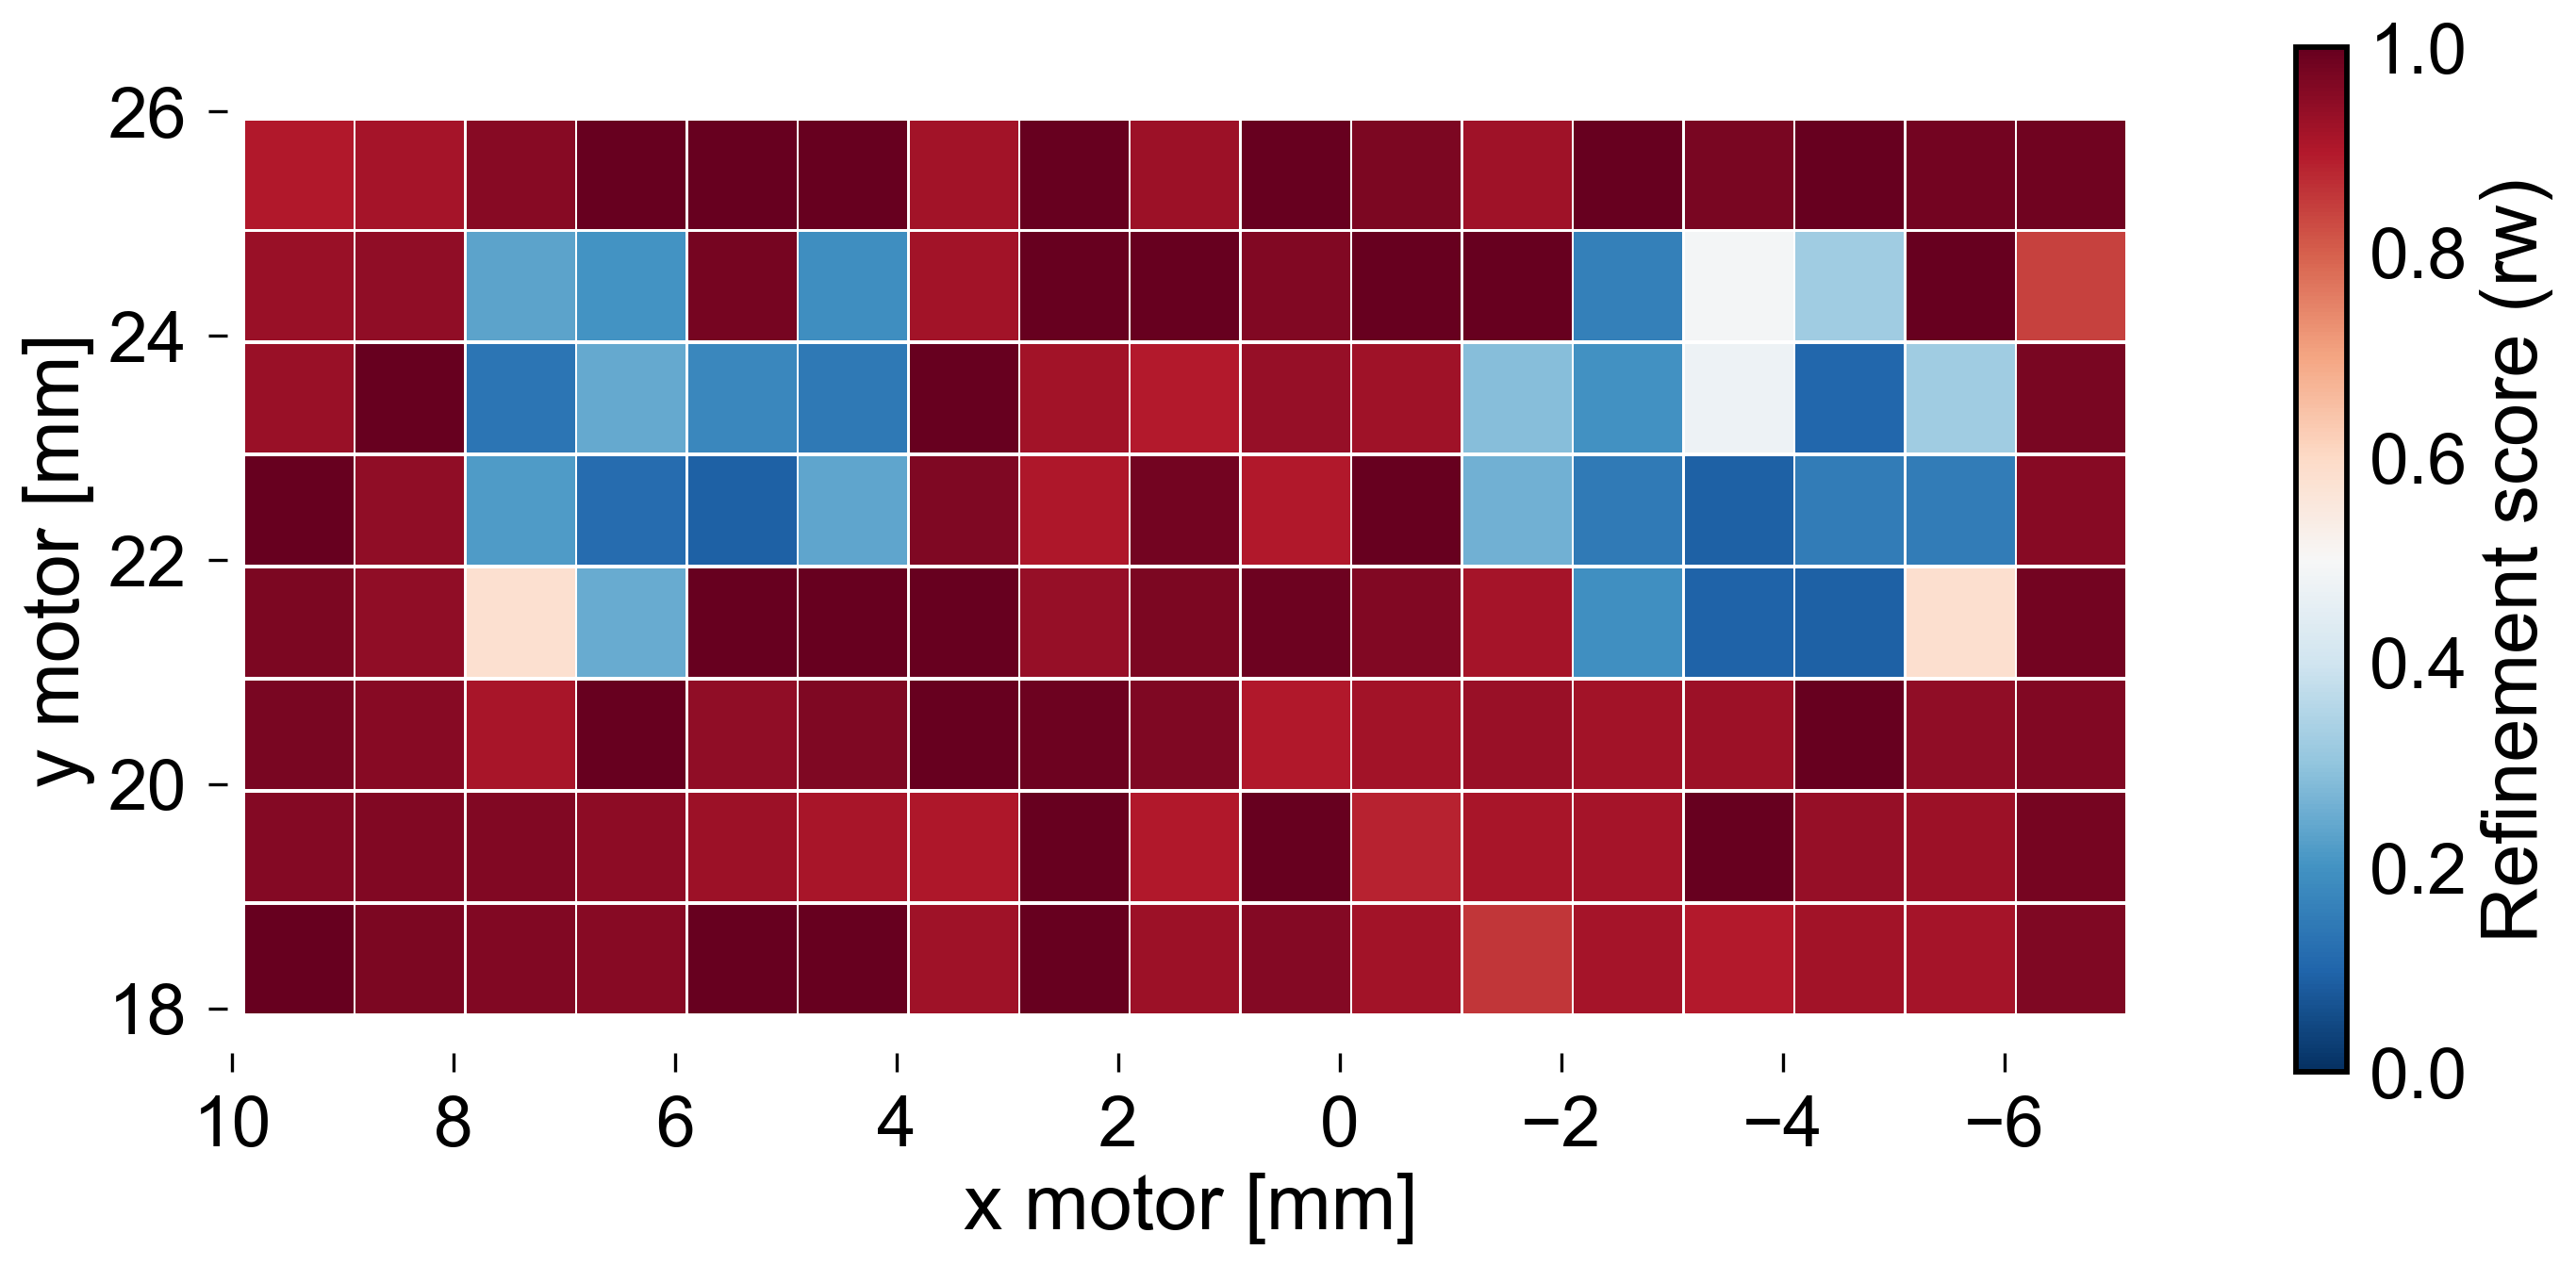

In [10]:
plt.figure(figsize=(14,6))
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.5)
for d in test_reload_2:
    plt.scatter(d['x'], d['y'], c=d['rw'],cmap = 'RdBu_r', vmin = 0, vmax = 1, marker = 's',s=1150)
    
#plt.xlim(10,-10)
plt.ylim(17.43,26.57)

#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plot = plt.colorbar()
plot.set_label('Refinement score (rw)')
plt.savefig('../../paper_17ak_spatial_PDF/figures/rw_gridscan_mpl.pdf',format='pdf')

In [13]:
# for elem in test_reload:
#     print ele
#pprint( test_reload_2[1])#elem['position'], elem['rw'])
# pprint([d for d in test_reload_2])# if d['x'] == '-32.518999999999998'])

In [23]:

print(test_reload_2[0].keys())
test_reload_3 = []
for t in test_reload_2:
    a = t.copy()
    if t['rw'] > .8:
        a.update({'psize': 900, 'lattice constant': 10})
    test_reload_3.append(a)
pprint(test_reload_3[0])

['q', 'rw', 'gr', 'g', 'I', 'gcalc', 'basename', 'r_fit', 'delta2_crystal1', 'number', 'psize', 'Pt_U1', 'Cu_U1', 'r', 'y', 'x', 's0', 'lattice constant', 'I_sub']
{'Cu_U1': 9.6581874418106162e-06,
 'I': array([  0.      ,   0.      ,   0.      , ...,  31.185684,  26.090527,
        27.905773]),
 'I_sub': array([ -1.18535103e-15,  -1.18535103e-15,  -1.18535103e-15, ...,
         3.95706195e-01,   2.47531591e+00,   9.40905495e+00]),
 'Pt_U1': 8.1050061905942047e-06,
 'basename': 'Catalyst_Array_DenseMap_075785_0001',
 'delta2_crystal1': 27.627180741514742,
 'g': array([-0.09320931, -0.08516083, -0.07692877, ..., -0.04316443,
       -0.03901774, -0.0342601 ]),
 'gcalc': array([-0.00378245, -0.00097944,  0.001444  , ..., -0.04304329,
       -0.04468978, -0.04530228]),
 'gr': array([ 0.        ,  0.00148803,  0.00302666, ..., -0.01330156,
       -0.01256399, -0.01149448]),
 'lattice constant': 10,
 'number': 1,
 'psize': 900,
 'q': array([  1.20462400e-01,   3.61387190e-01,   6.02312030e-0

In [24]:
df = pd.DataFrame(test_reload_3)

In [33]:
# df.ix[:,['basename','x','y','rw']]
# df.pivot('x','y')
pivot = pd.pivot_table(df,values='rw',index='y',columns='x')
#df.pivot('x','y','rw')

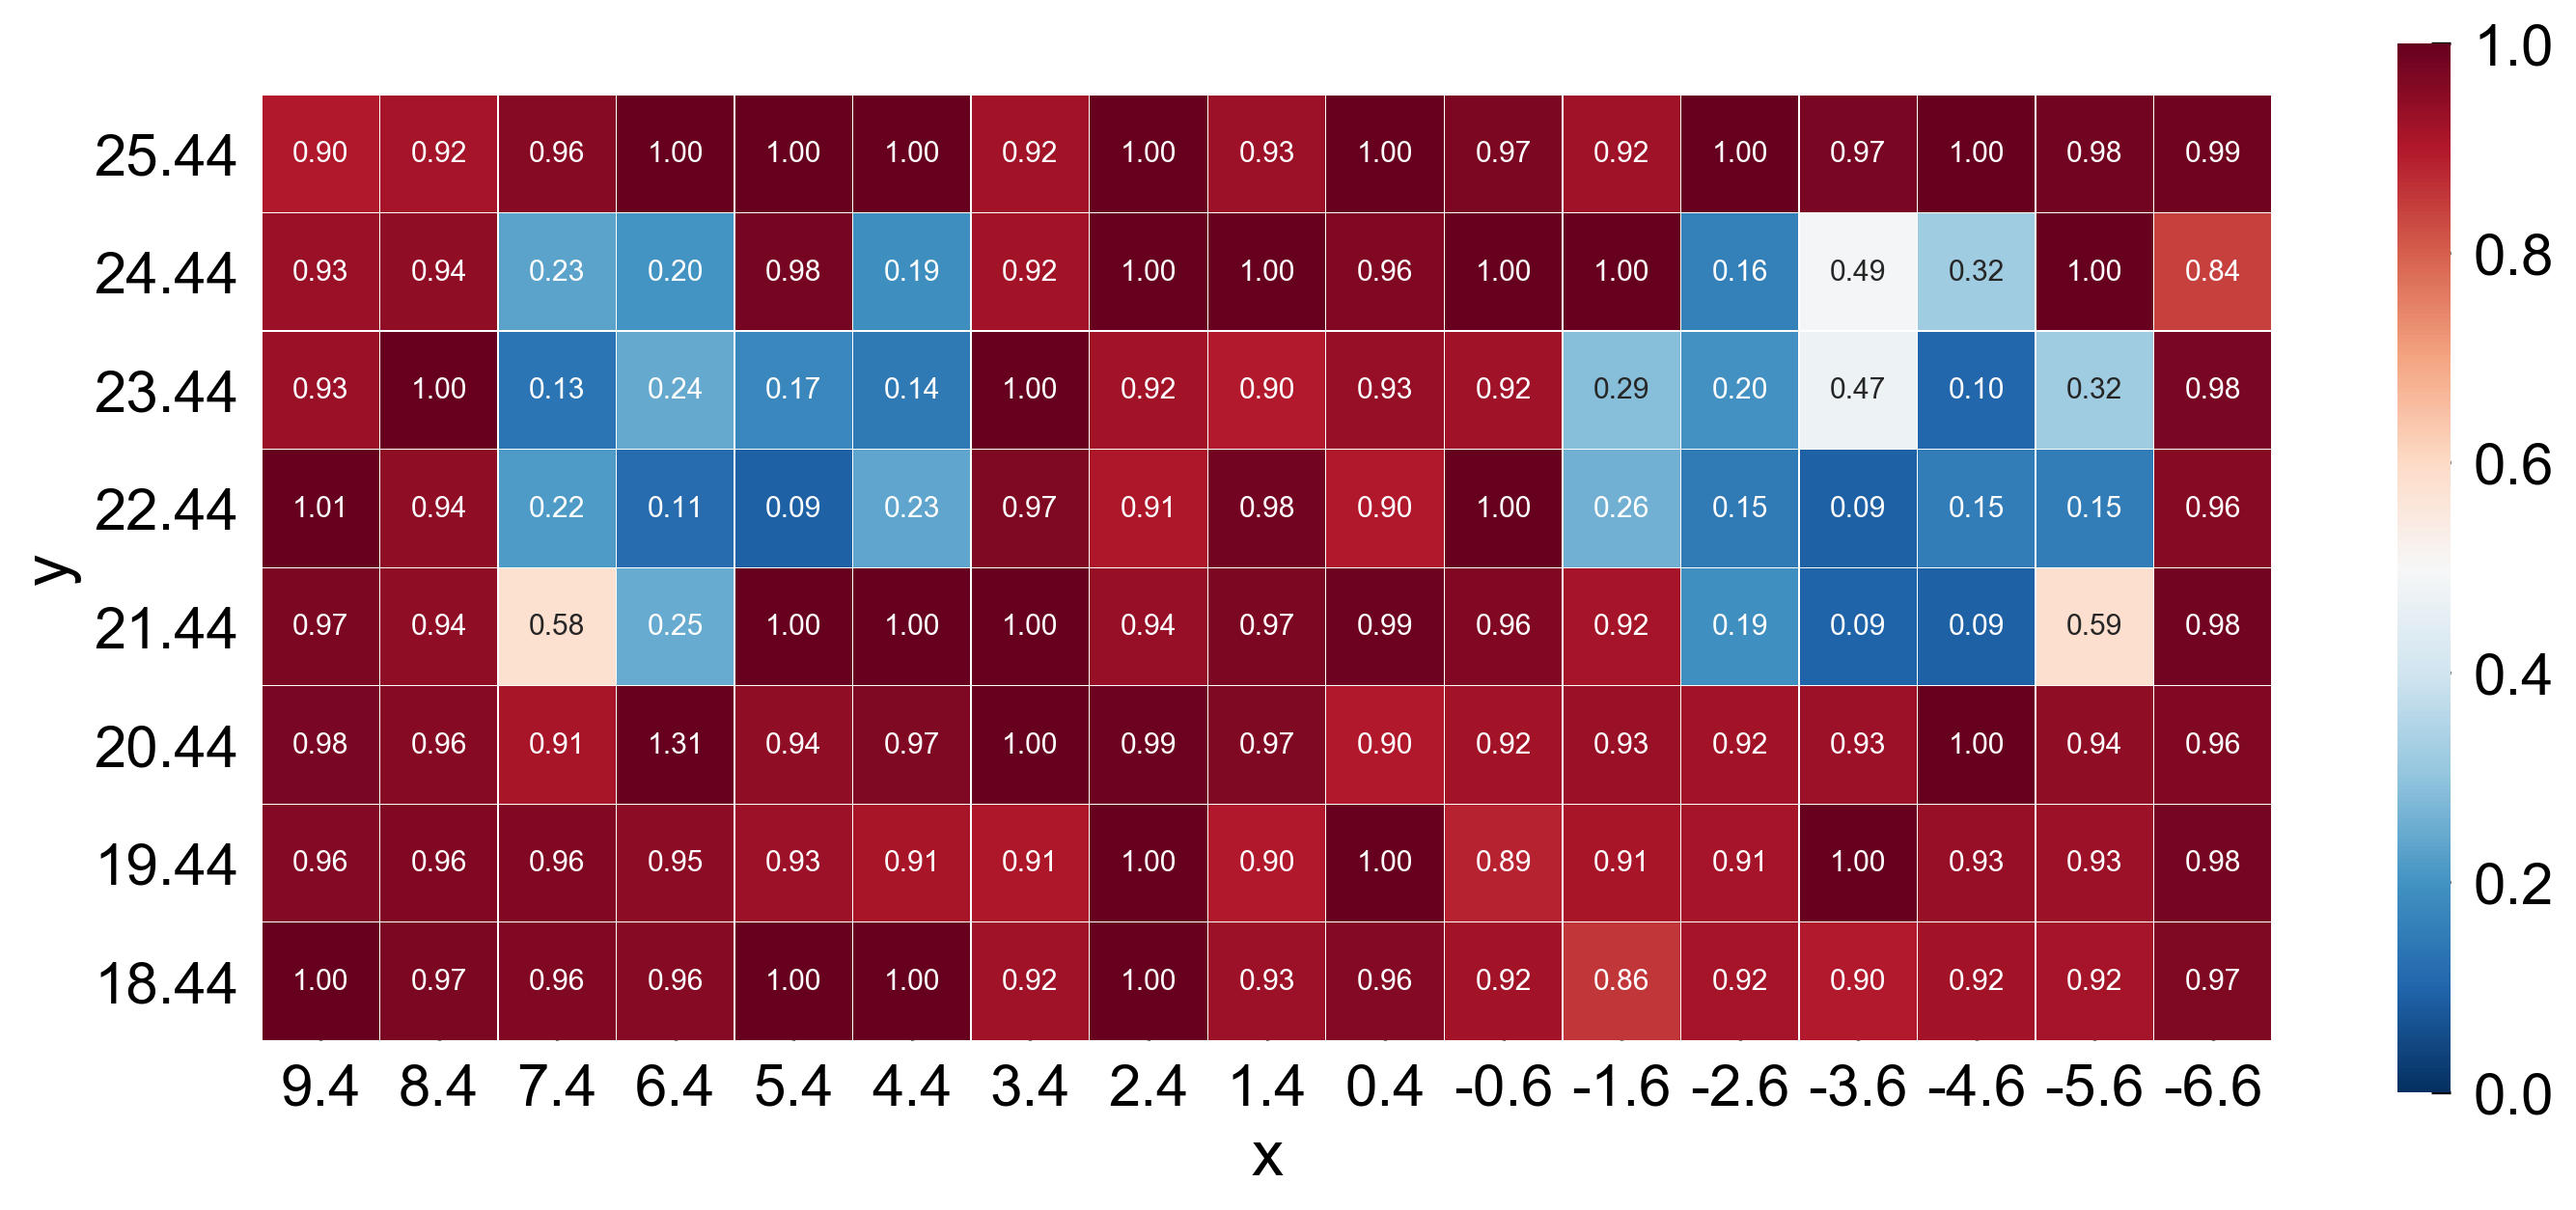

In [45]:
plt.figure(figsize=(14,6))

grid_heatmap_2 = (df.pivot('x','y','rw'))

pivot = pd.pivot_table(df,values='rw',index='y',columns='x')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 0.5, cbar = True, vmin=0, vmax=1);
ax.invert_xaxis()
ax.invert_yaxis()
plt.savefig('rw_gridscan.pdf',format='pdf')

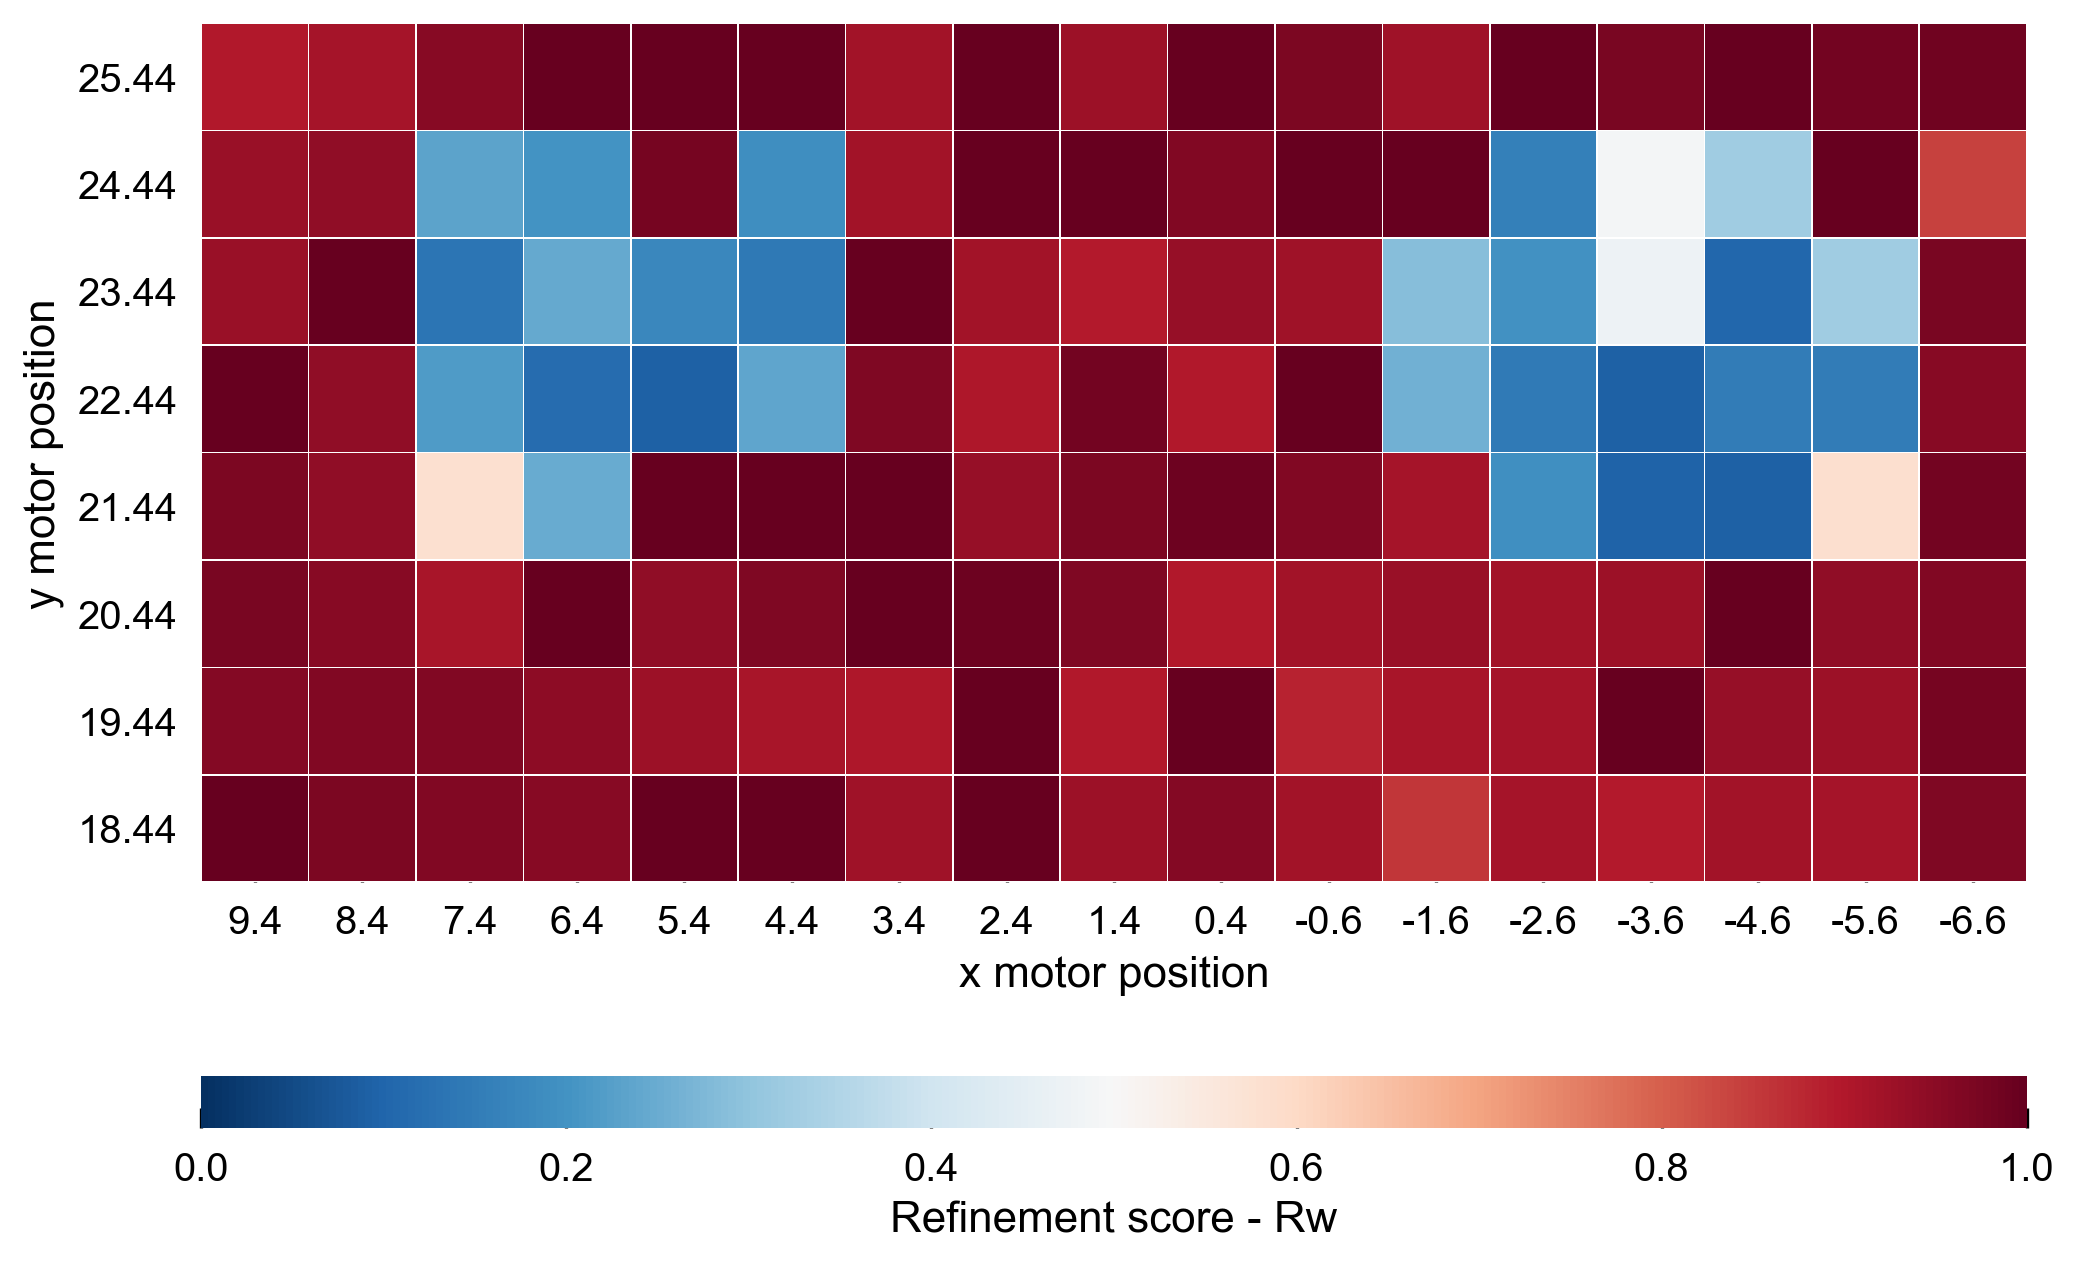

In [96]:
plt.figure(figsize=(14,6))
grid_heatmap_2 = (df.pivot('x','y','rw'))
pivot = pd.pivot_table(df,values='rw',index='y',columns='x')

bSeabornStyle(ticks=True, cycle='simon2', f_scale=0.8)

grid_kws = {"height_ratios": (.99, .05), "hspace": None}
f, ( ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)



ax = sns.heatmap(pivot, ax=ax, annot = False,annot_kws={"size": 9}, fmt=".1f",cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal","label": "Refinement score - Rw"},
                 linewidths=0.2, square = True,
                 cmap = 'RdBu_r',center = 0.5, cbar = True, vmin=0.15, vmax=1);

#ax.xaxis.tick_top()
ax.set_xlabel('x motor position')
ax.set_ylabel('y motor position')
#ax.xaxis.set_label_position('top') 

f.tight_layout()

#ax.subplots(wspace=None, hspace=None)

ax.invert_xaxis()
ax.invert_yaxis()
plt.savefig('rw_gridscan.pdf',format='pdf')

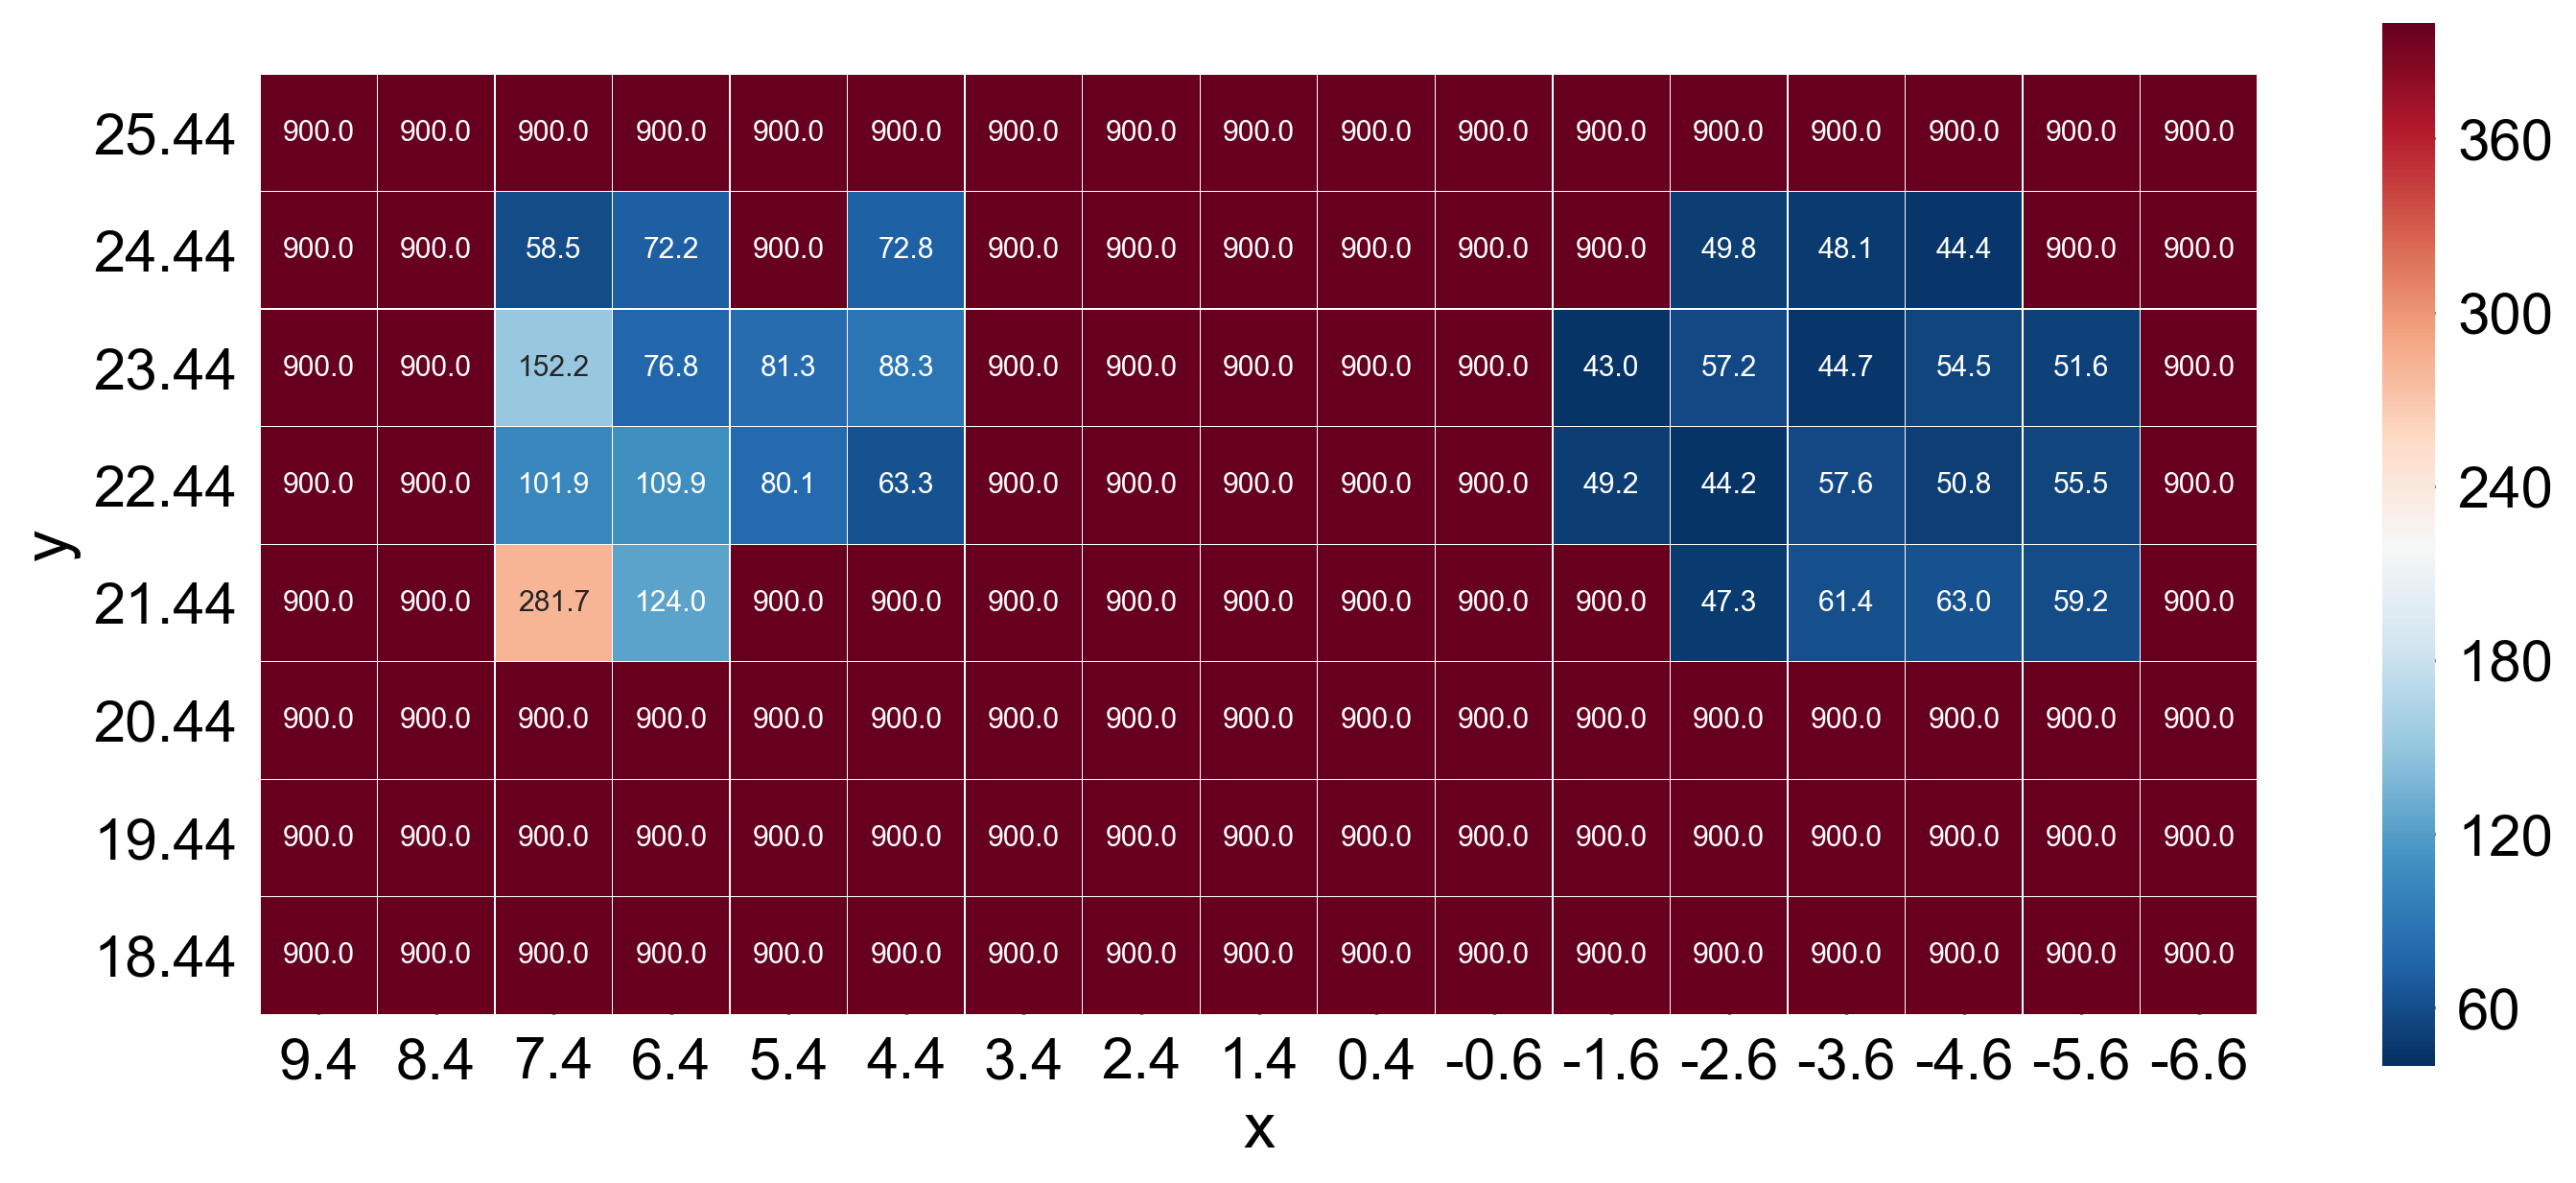

In [29]:
plt.figure(figsize=(14,6))
pivot = pd.pivot_table(df,values='psize',index='y',columns='x')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".1f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 220, cbar = True, vmin=40, vmax=400);
ax.invert_yaxis()
ax.invert_xaxis()
#plt.savefig('psize_gridscan.pdf',format='pdf')

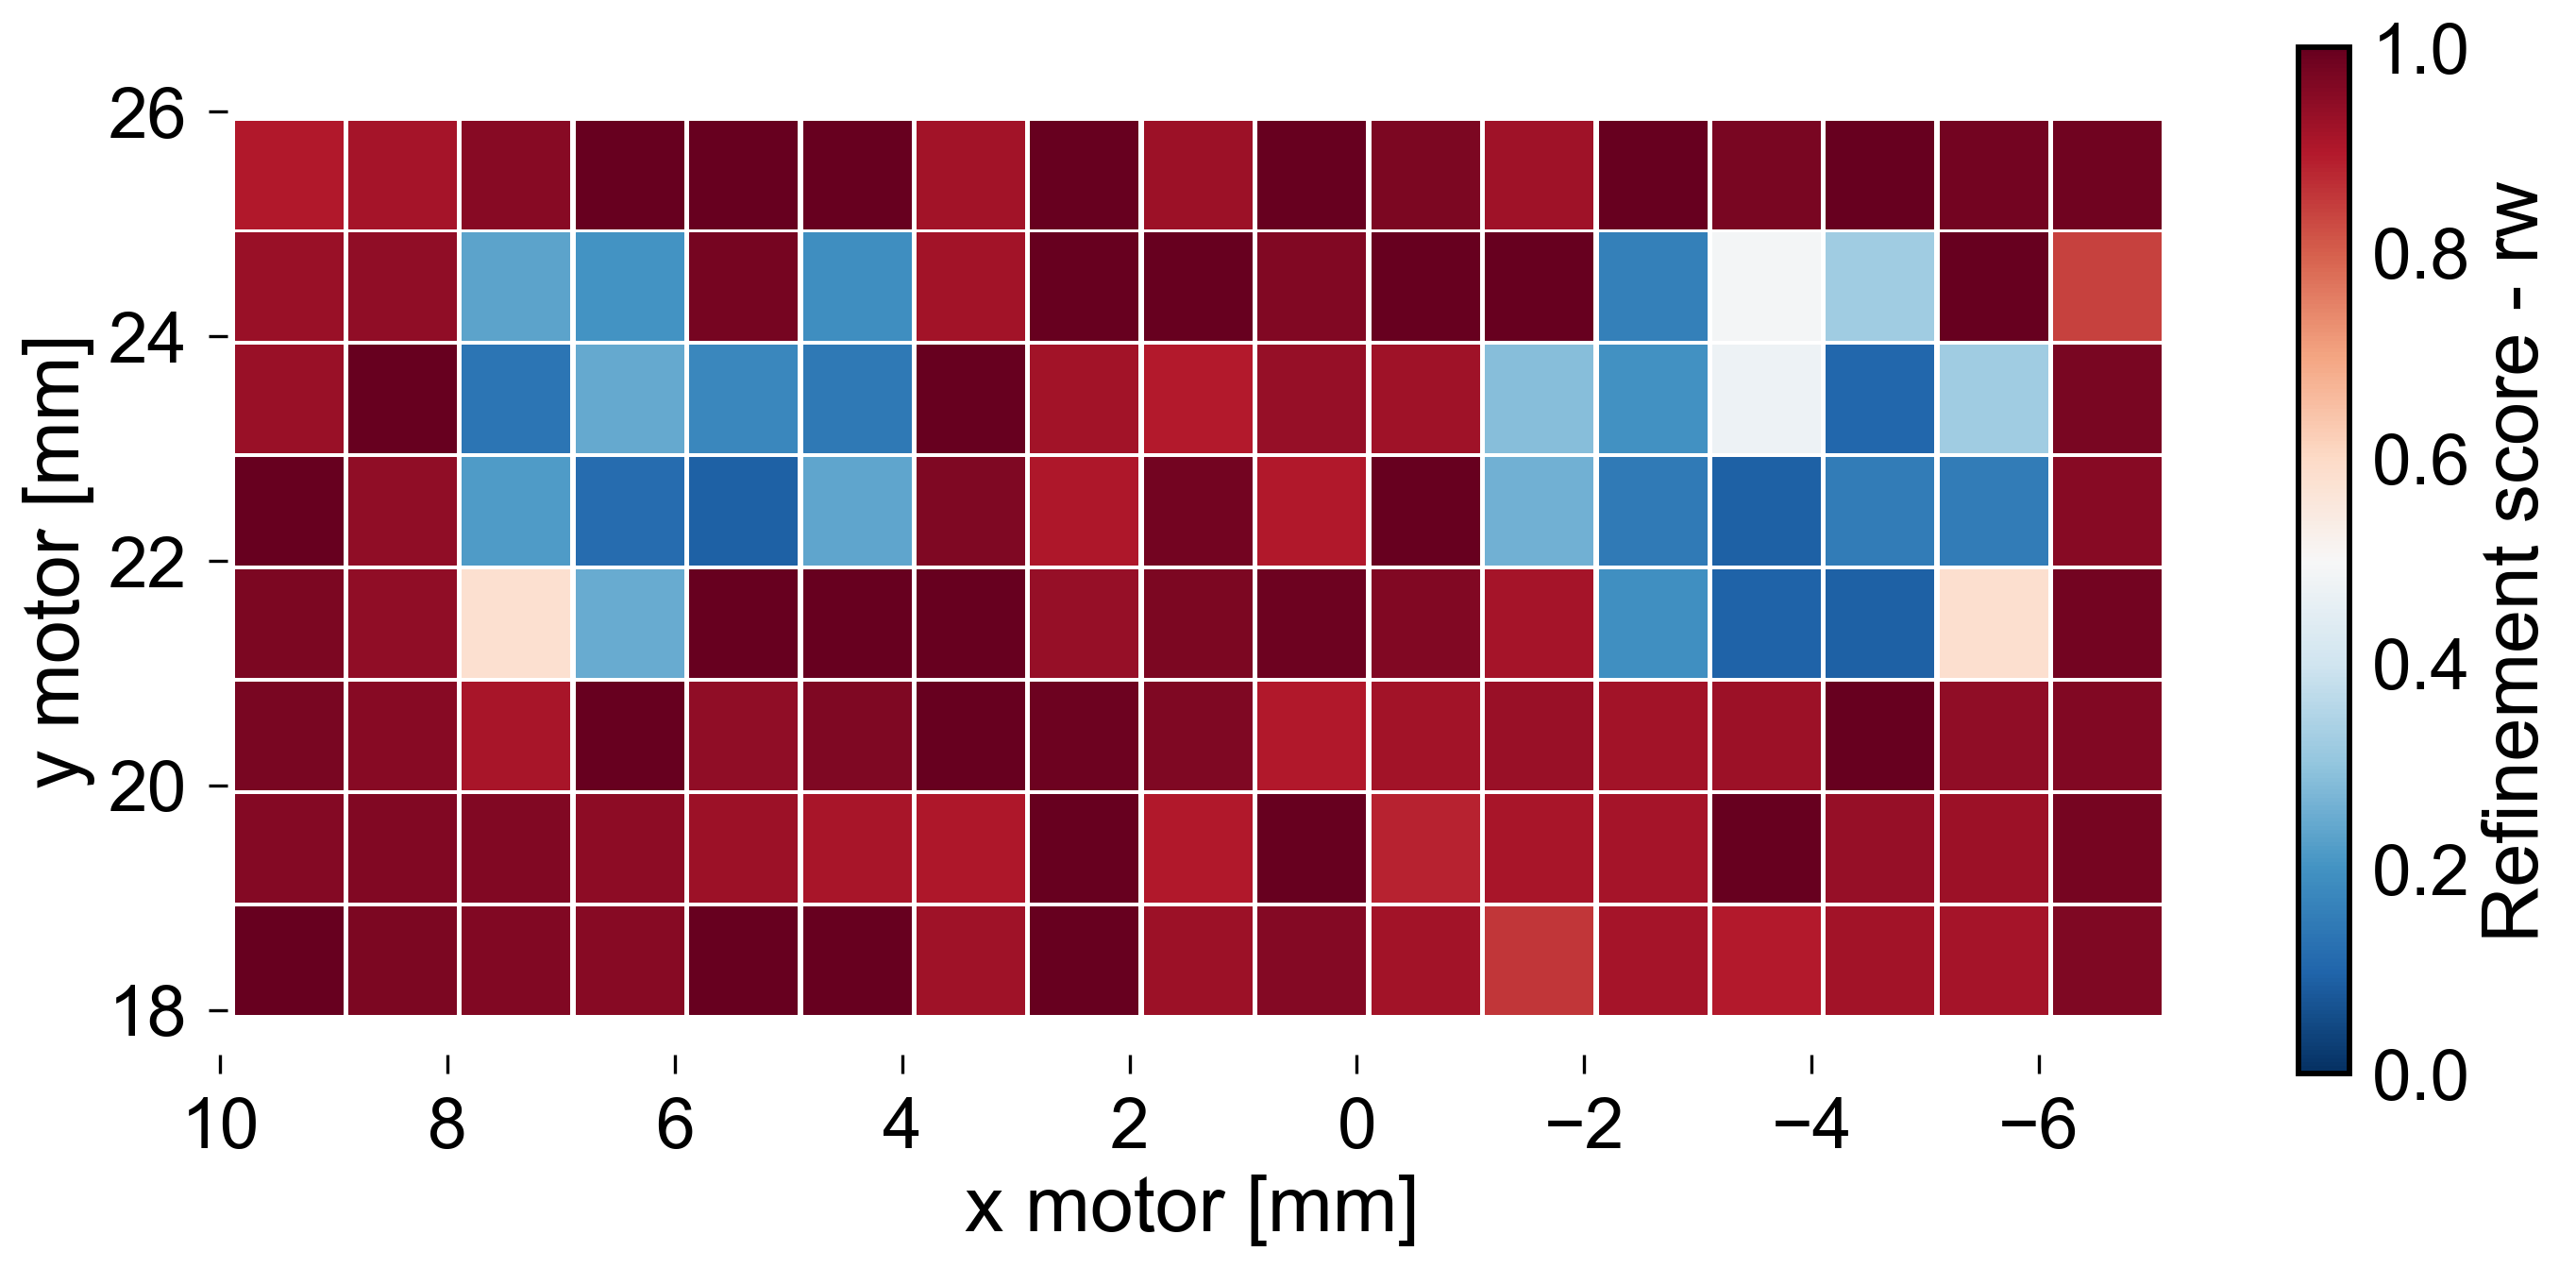

In [12]:
plt.figure(figsize=(14,6))
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.5)
for d in test_reload_2:
        plt.scatter(d['x'], d['y'], c=d['rw'],cmap = 'RdBu_r', vmin = 0, vmax = 1, marker = 's',s=1150)
    
plt.xlim(-7.2,10.1)
plt.ylim(17.43,26.57)

#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plot = plt.colorbar()
plot.set_label("Refinement score - rw")
plt.savefig('../../paper_17ak_spatial_PDF/figures/psize_gridscan_mpl.pdf',format='pdf')

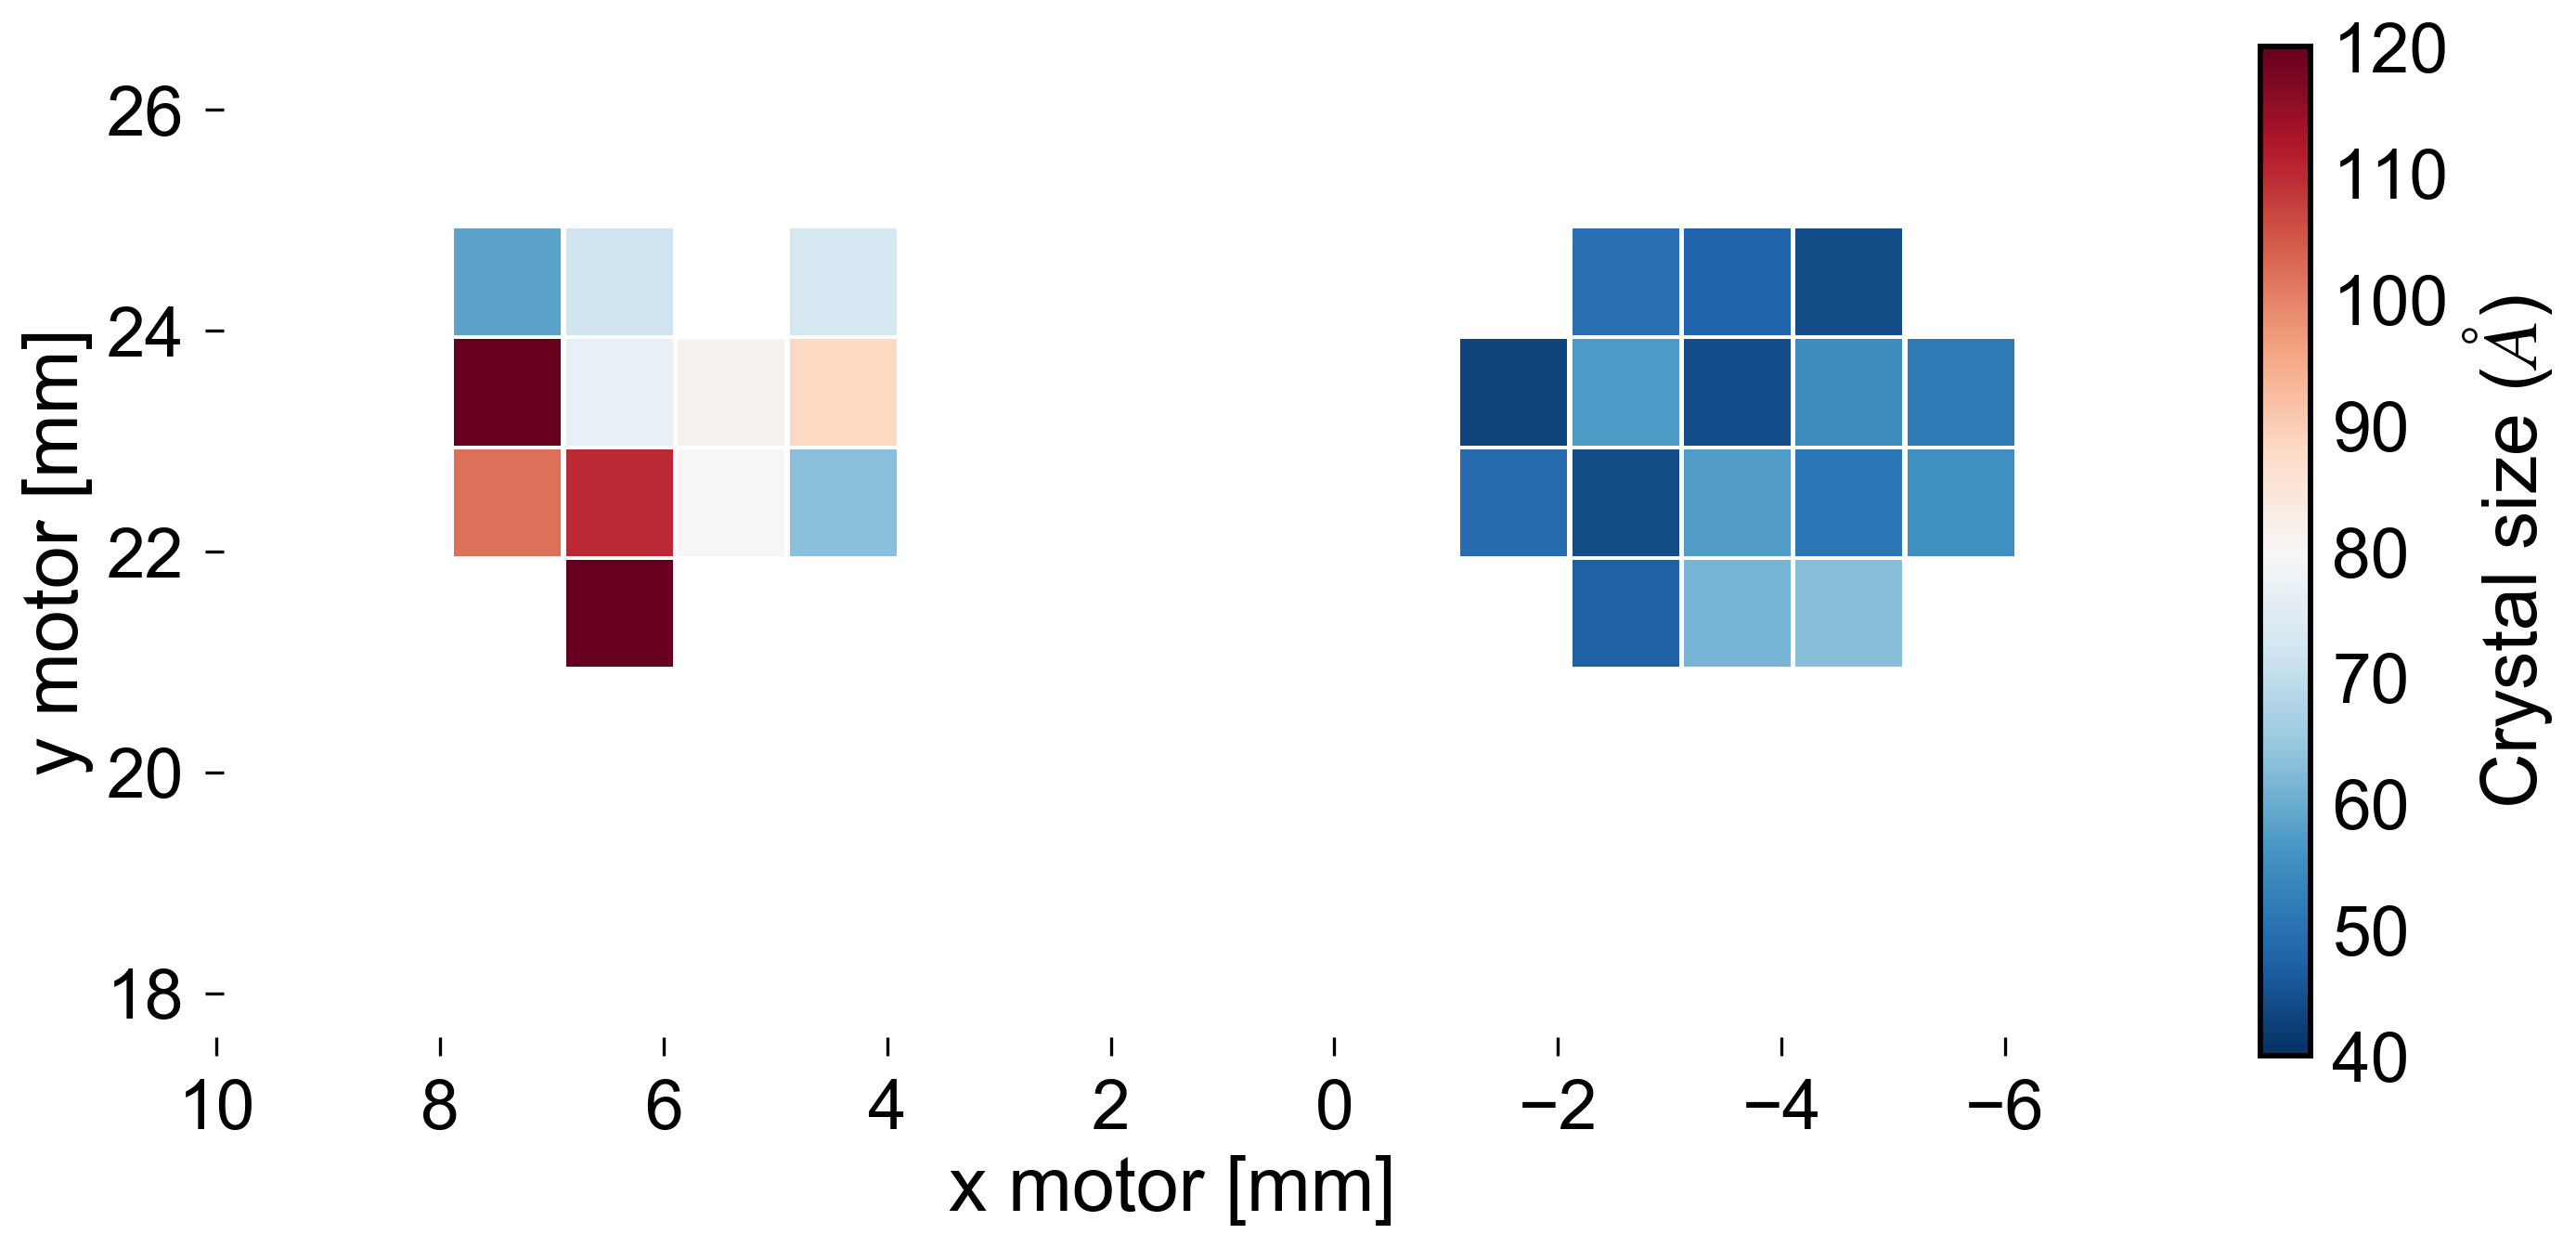

In [13]:
plt.figure(figsize=(14,6))
bSeabornStyle(ticks=True, cycle='simon2', f_scale=1.5)
for d in test_reload_2:
    if d['rw']<0.5:
        plt.scatter(d['x'], d['y'], c=d['psize'],cmap = 'RdBu_r', vmin = 40, vmax = 120, marker = 's',s=1150)
    
plt.xlim(-7.2,10.1)
plt.ylim(17.43,26.57)

#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plot = plt.colorbar()
plot.set_label('Crystal size ($\AA$)')
plt.savefig('../../paper_17ak_spatial_PDF/figures/psize_gridscan_mpl.pdf',format='pdf')

## Combined plot

## 1D Slicing plot

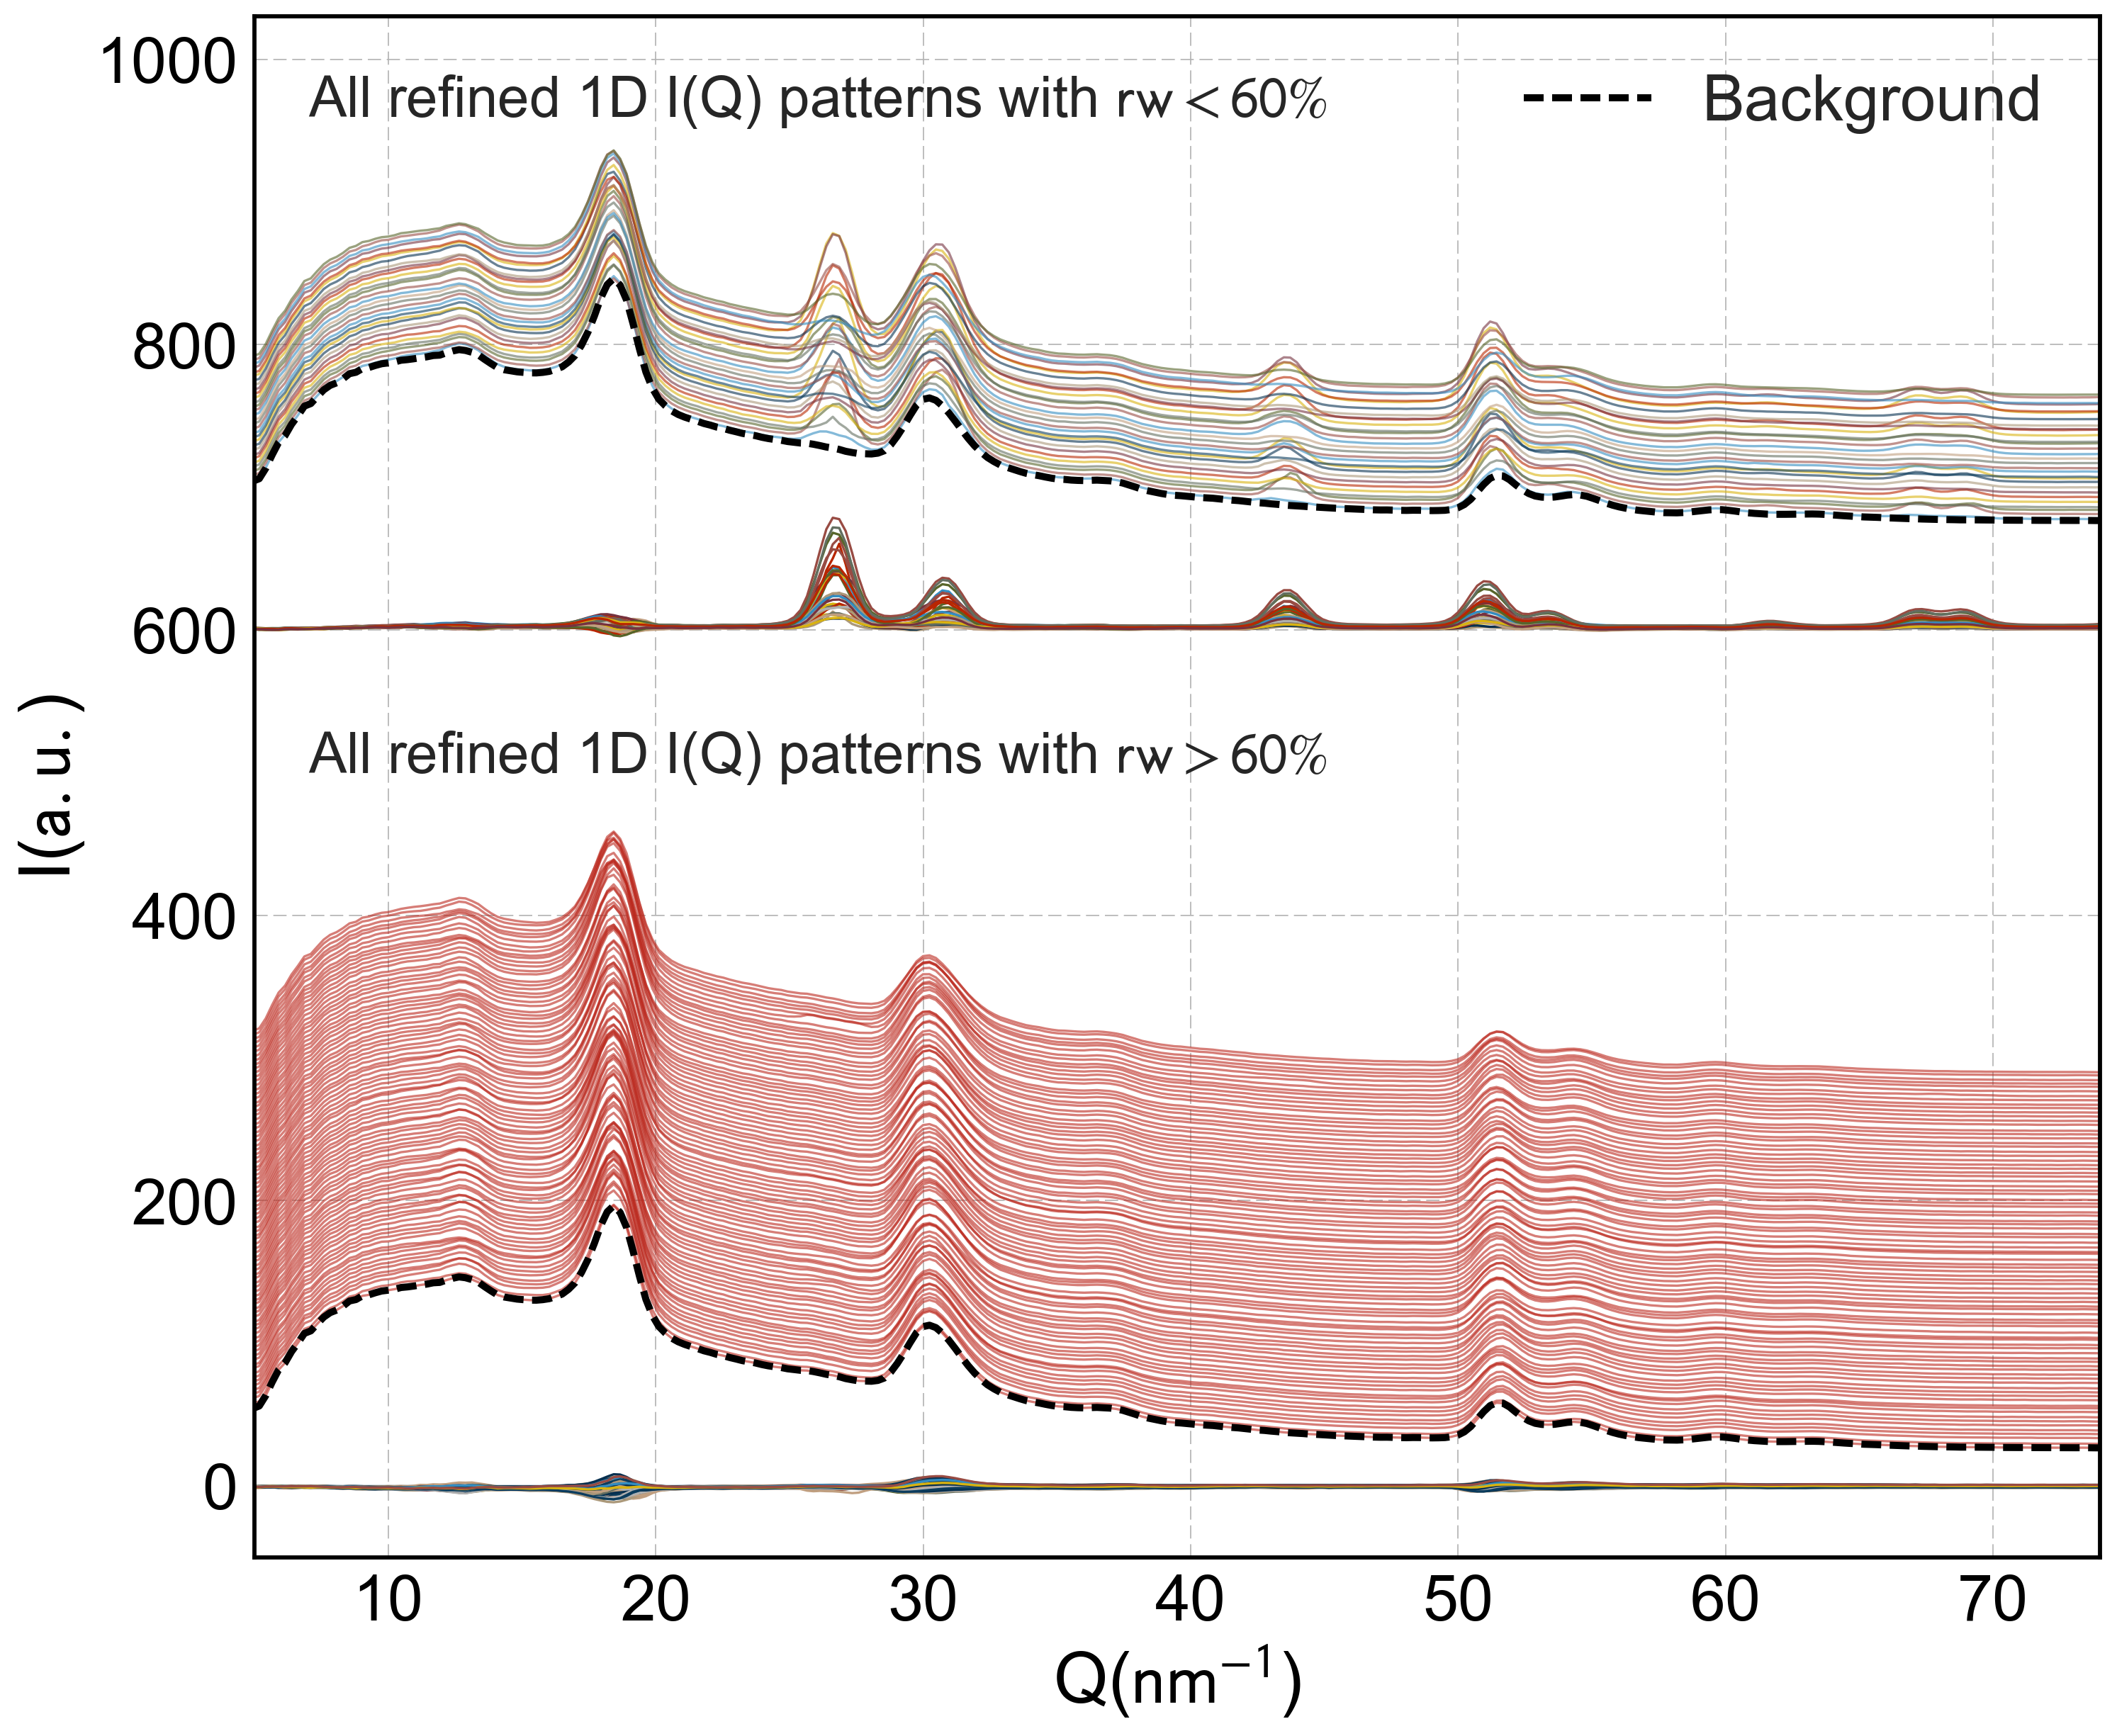

In [111]:
# Use another SNS preset: deep, muted, bright, pastel, dark, colorblind
bSeabornStyle(cycle='simon', f_scale=1.8)
fig, ((ax1)) = plt.subplots(1, 1, figsize=[14,12])#,gridspec_kw = {'height_ratios':[2, 1]})

q, Iq = np.genfromtxt('./Catalyst_Array_DenseMap/bkgd/Catalyst_Array_DenseMap_075785_0001.chi', skip_header=4).T

i=0
increment=0
for d in test_reload_2:
    if d['rw']<0.6:
        ax1.plot(d['q'], d['I']+650+i, lw=1,alpha=0.6)#,color='#0b190b')
        ax1.plot(d['q'], d['I']-np.interp(d['q'],q,Iq)+600, lw=1)
        
        i=i+3
    if d['rw']>0.6 and d['rw']<1:
        ax1.plot(d['q'], d['I']+increment, lw=1,alpha=0.6,color='#bb271c')#color='#e02141')#color='#2d090e')
        ax1.plot(d['q'], np.interp(d['q'],q,Iq)-d['I'], lw=1)
        increment=increment+3
ax1.plot(q,Iq,lw=3,ls='--',label = 'Background',color='black')
ax1.plot(q,Iq+650,lw=3,ls='--',color='black')



ax1.set_xlim(5,74)
ax1.set_ylim(-50,1030)
plt.legend()
ax1.set_ylabel('I($\mathrm{a.u.}$)') 
ax1.set_xlabel('Q($\mathrm{nm^{-1}}$)')
ax1.text(7, 500, 'All refined 1D I(Q) patterns with $\mathrm{rw>60\%}$', fontsize=24)
ax1.text(7, 960, 'All refined 1D I(Q) patterns with $\mathrm{rw<60\%}$', fontsize=24)


#plt.savefig('../../paper_17ak_map_PDF/figures/1d_slicing.png',format='png',dpi=300)

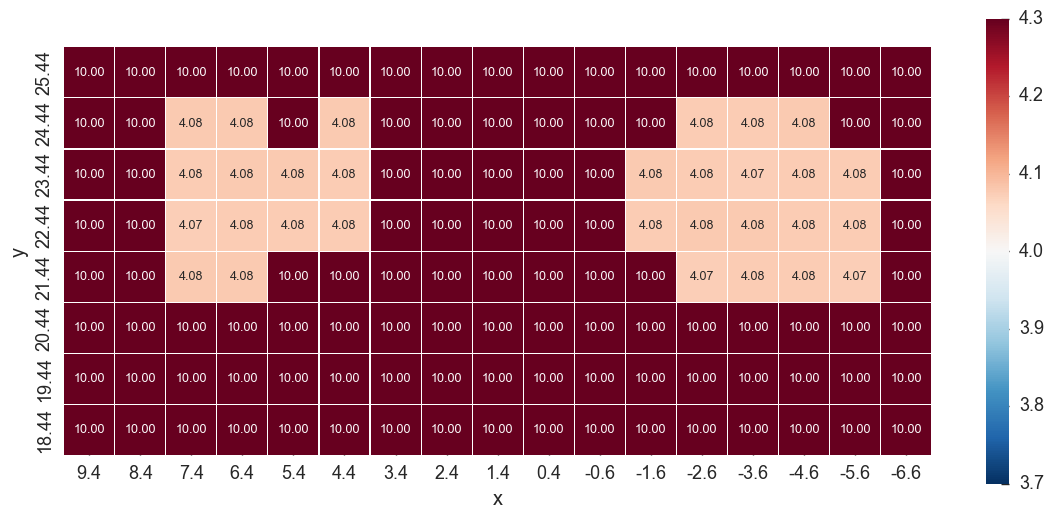

In [76]:
plt.figure(figsize=(14,6))
pivot = pd.pivot_table(df,values='lattice constant',index='y',columns='x')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 4., cbar = True, vmin=3.7, vmax=4.2);
ax.invert_yaxis()
ax.invert_xaxis()
plt.savefig('lat_gridscan.pdf',format='pdf')

NameError: name 'event_list' is not defined

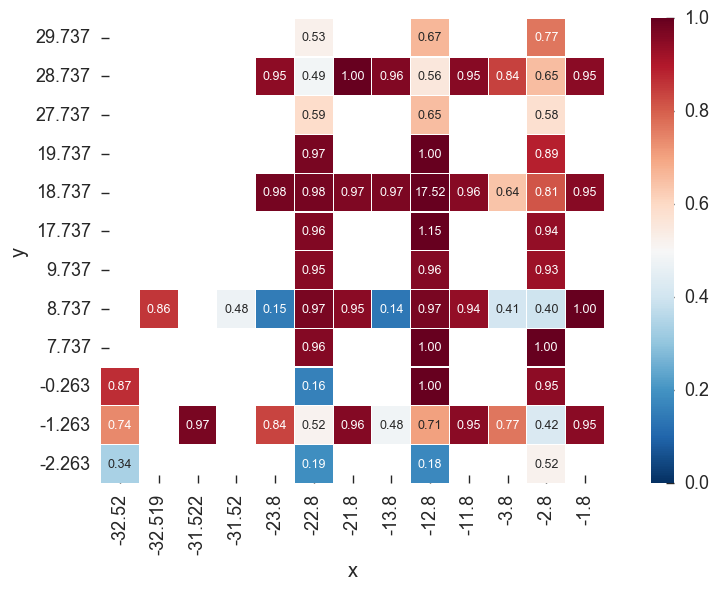

In [12]:
plt.figure(figsize=(12,6))
# grid_heatmap_2 = (df.pivot('x','y','rw'))
ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 0.5, cbar = True, vmin=0, vmax=1);
#ax.invert_xaxis()
ax.invert_yaxis()



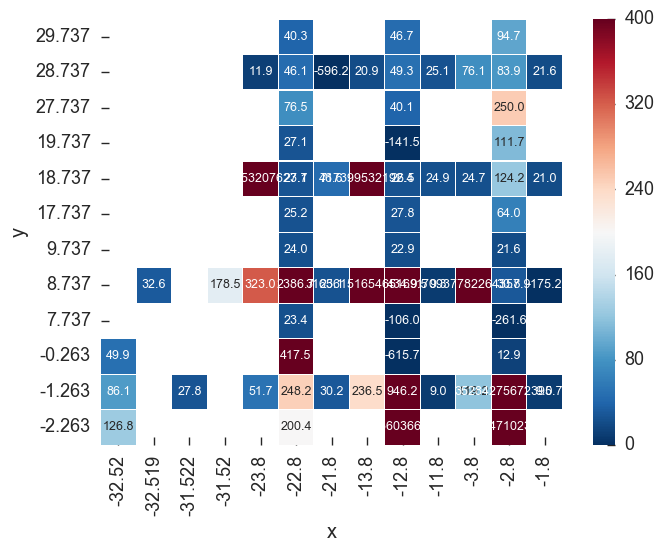

In [13]:
pivot = pd.pivot_table(df,values='psize',index='y',columns='x')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".1f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 200, cbar = True, vmin=0, vmax=400);
ax.invert_yaxis()

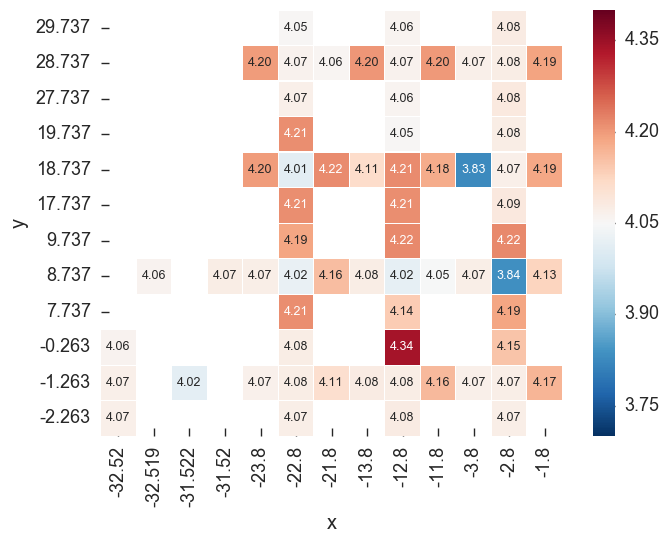

In [14]:
pivot = pd.pivot_table(df,values='lattice constant',index='y',columns='x')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 4.05, cbar = True, vmin=3.7, vmax=4.3);
ax.invert_yaxis()

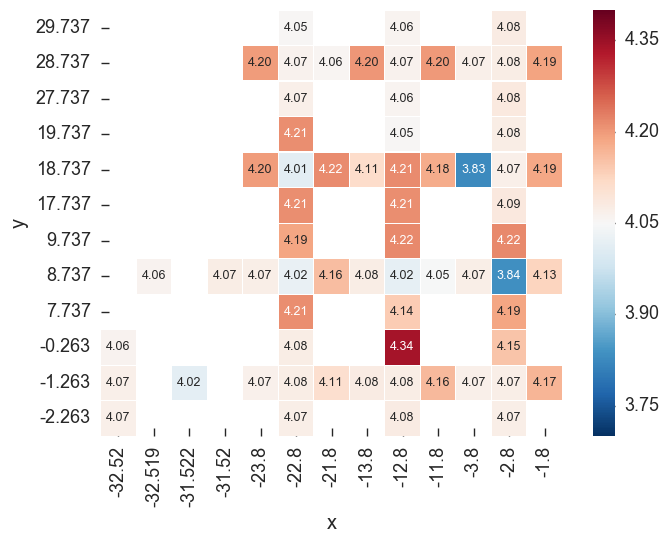

In [15]:
pivot = pd.pivot_table(df,values='lattice constant',index='y',columns='x')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 4.05, cbar = True, vmin=3.7, vmax=4.3);
ax.invert_yaxis()

In [75]:
df = pd.DataFrame(test_reload_2)
# df.ix[:,['basename','x','y','rw']]
# df.pivot('x','y')
pivot = pd.pivot_table(df,values='rw',index='y',columns='x')
#df.pivot('x','y','rw')

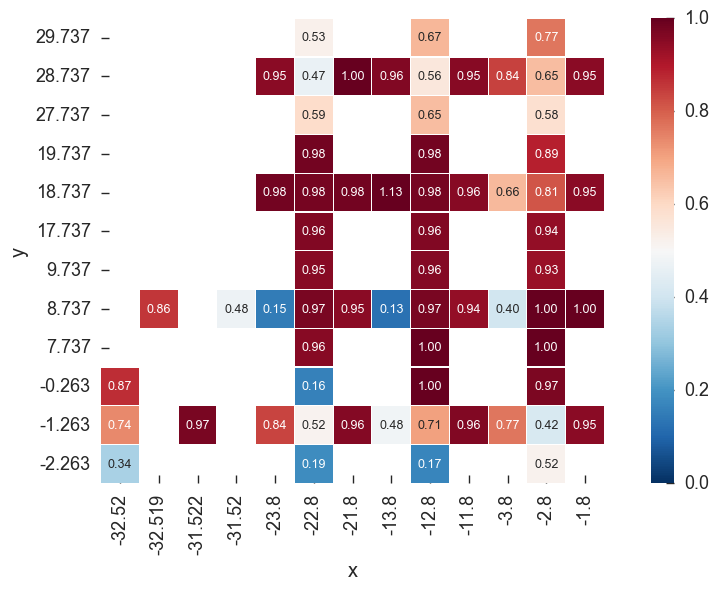

In [76]:
plt.figure(figsize=(12,6))
# grid_heatmap_2 = (df.pivot('x','y','rw'))
ax2 = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 0.5, cbar = True, vmin=0, vmax=1);
#ax.invert_xaxis()
ax2.invert_yaxis()

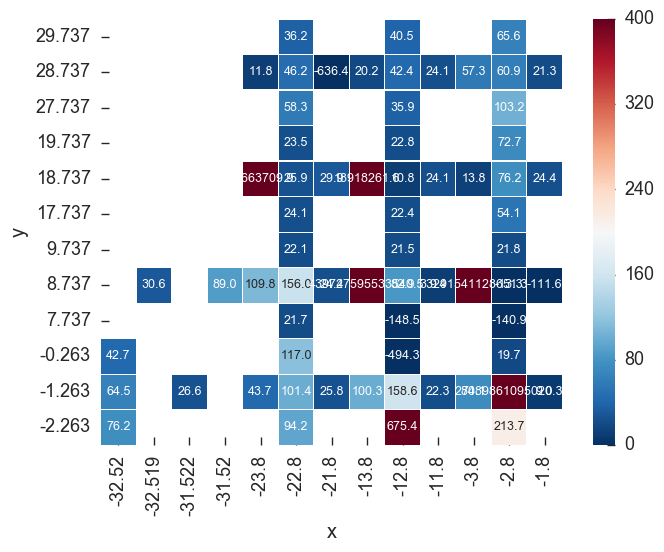

In [77]:
pivot = pd.pivot_table(df,values='psize',index='y',columns='x')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".1f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 200, cbar = True, vmin=0, vmax=400);
ax.invert_yaxis()

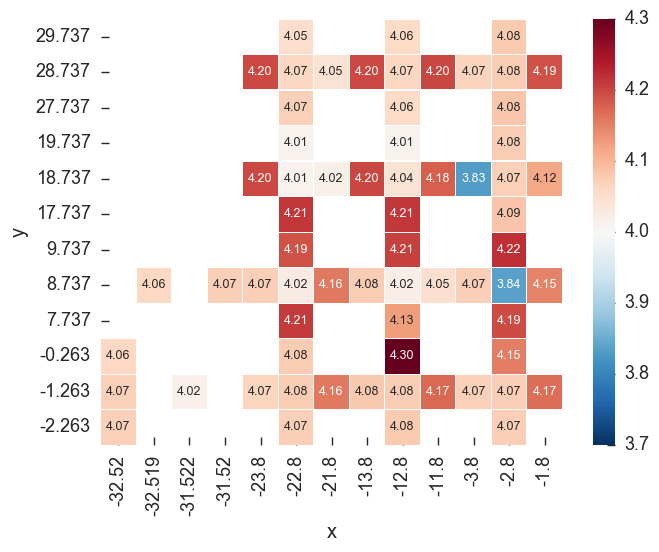

In [83]:
pivot = pd.pivot_table(df,values='lattice constant',index='y',columns='x')

ax = sns.heatmap(pivot, annot = True,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu_r',center = 4., cbar = True, vmin=3.7, vmax=4.2);
ax.invert_yaxis()

In [86]:
pprint([[d['basename'],d['rw'],d['composition'],d['position']] for d in test_reload_2 if d['rw'] > 0.8])

# rw_list = [[d['basename'],d['rw']] for d in test_reload_2 if d['rw'] < 0.6]

# for i in rw_list:
#     pprint(i)

#pprint([[d['basename'],d['rw'],d['composition']] for d in test_reload_2 if d['rw'] < 0.6])



[['sub_catalyst_array_20160803_0311', 0.85839226307831507, 'PtPb', '1_3'],
 ['sub_catalyst_array_20160803_0312', 0.86894543447307004, 'PbCu', '1_4'],
 ['sub_catalyst_array_20160803_0313', 0.89456937972420458, 'PbCu', '1_4'],
 ['sub_catalyst_array_20160803_0318', 0.97302099512247764, 'PbCu', '1_4'],
 ['sub_catalyst_array_20160803_0325', 0.99999999999999967, 'AuAg', '2_1'],
 ['sub_catalyst_array_20160803_0326', 0.94941109009282376, 'AuAg', '2_1'],
 ['sub_catalyst_array_20160803_0327', 0.98060183468424045, 'AgPt', '2_2'],
 ['sub_catalyst_array_20160803_0329', 0.97761647789991291, 'AgPt', '2_2'],
 ['sub_catalyst_array_20160803_0330', 0.96302532669406604, 'AgPt', '2_2'],
 ['sub_catalyst_array_20160803_0333', 0.98433251543754308, 'AgPt', '2_2'],
 ['sub_catalyst_array_20160803_0334', 0.98156916417786499, 'AgPt', '2_2'],
 ['sub_catalyst_array_20160803_0335', 0.95476289776163736, 'PtPb', '2_3'],
 ['sub_catalyst_array_20160803_0336', 0.97460255809800234, 'PtPb', '2_3'],
 ['sub_catalyst_array_201

### Anton Testing

In [36]:
for d in event_list[22:66]:
    print d

{'delta2_crystal1': 3.953423250611444, 'gr': array([ 0.        , -0.00356038, -0.00706054, ..., -0.00609541,
       -0.00762392, -0.0086282 ]), 'scan': 6, 'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), 'basename': 'sub_catalyst_array_20160803_0346', 'psize': 417.47797216589811, 'position': '2_4', 'Pt_U1': 0.0094508449741267184, 'rw': 0.16289985935425716, 'lattice constant': 4.0751387148242921, 's0': 0.50535693315588337, 'q': array([  1.08523830e-01,   3.25571480e-01,   5.42619170e-01, ...,
         3.20036770e+02,   3.20253810e+02,   3.20470890e+02]), 'Cu_U1': 0.011677799565124339, 'r': array([  0.00000000e+00,   1.00000000e-02,   2.00000000e-02, ...,
         9.99800000e+01,   9.99900000e+01,   1.00000000e+02]), 'y': -0.26300000000000001, 'x': -22.800000000000001, 'I_subtr_resc': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), 'composition': 'PbCu'}
{'gr': array([ 0.        ,  0.00766332,  0.01494992, ..., -0.02512564,
       -0.02687908, -0.02752758]), 'scan': 6, 'I': array([ 0.,  0., 

In [14]:
pprint([x for x in event_list if x['composition'] == 'PtPb'])



[{'Cu_U1': 0.0050771850704590255,
  'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_subtr_resc': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'Pt_U1': 0.018084926203597432,
  'basename': 'sub_catalyst_array_20160803_0310',
  'composition': 'PtPb',
  'delta2_crystal1': 4.3305014381754914,
  'gr': array([ 0.        ,  0.01314541,  0.02570006, ..., -0.01722943,
       -0.01819515, -0.0183962 ]),
  'lattice constant': 4.0748501151505074,
  'position': '1_3',
  'psize': 178.54986258666466,
  'q': array([  1.08523830e-01,   3.25571480e-01,   5.42619170e-01, ...,
         3.20036770e+02,   3.20253810e+02,   3.20470890e+02]),
  'r': array([  0.00000000e+00,   1.00000000e-02,   2.00000000e-02, ...,
         9.99800000e+01,   9.99900000e+01,   1.00000000e+02]),
  'rw': 0.47588739177740713,
  's0': 0.24019334089880193,
  'scan': 1,
  'x': -31.52,
  'y': 8.7370000000000001},
 {'Cu_U1': 0.0051834344170454665,
  'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_subtr_resc': array([ 0.,  0

# Preparing the test dataset

In [110]:
print(test_reload_2[0].keys())

names_list = []

for t in test_reload_2:
    if t['rw'] > 0.25 and t['rw']< 0.6 :
        names_list.append(t['basename'])

['q', 'rw', 'gr', 'g', 'I', 'gcalc', 'basename', 'r_fit', 'delta2_crystal1', 'number', 'psize', 'Pt_U1', 'Cu_U1', 'r', 'y', 'x', 's0', 'lattice constant', 'I_sub']


In [114]:
sim_data_save = './../../paper_17ak_map_PDF/simulated_dataset/test/'

for i in names_list:
    for d in test_reload_2:
        if d['basename'] == i:
            print d['basename']
            stack = np.vstack((d['q'],d['I']))
            np.savetxt(sim_data_save+d['basename']+'.chi',stack.T, delimiter='\t')
            
#     pprint([d for d in test_reload_2])# if d['basename'] == i

Catalyst_Array_DenseMap_075785_0021
Catalyst_Array_DenseMap_075785_0093
Catalyst_Array_DenseMap_075785_0094
Catalyst_Array_DenseMap_075785_0110
Catalyst_Array_DenseMap_075785_0111
Catalyst_Array_DenseMap_075785_0114
Catalyst_Array_DenseMap_075785_0124
Catalyst_Array_DenseMap_075785_0126


In [112]:
all_mat = np.genfromtxt('../../paper_17ak_map_PDF/simulated_dataset/source_lists/mapPDF_all_material.csv',delimiter = ',')
print all_mat
all_mat = all_mat[~np.isnan(all_mat)]
print all_mat
len(all_mat)

[[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   30.   31.   32.   nan   nan   nan   nan]
 [  nan   nan   nan   40.   41.   42.   43.   44.   45.   nan   nan   nan]
 [  nan   nan   51.   52.   53.   54.   55.   56.   57.   58.   nan   nan]
 [  nan   nan   63.   64.   65.   66.   67.   68.   69.   70.   nan   nan]
 [  nan   nan   75.   76.   77.   78.   79.   80.   81.   82.   nan   nan]
 [  nan   nan   87.   88.   89.   90.   91.   92.   93.   94.   nan   nan]
 [  nan   nan   99.  100.  101.  102.  103.  104.  105.  106.   nan   nan]
 [  nan   nan  111.  112.  113.  114.  115.  116.  117.  118.   nan   nan]
 [  nan   nan  123.  124.  125.  126.  127.  128.  129.  130.   nan   nan]
 [  nan   nan  135.  136.  137.  138.  139.  140.  141.  142.   nan   nan]
 [  nan   nan  147.  148.  149.  150.  151.  152.  153.  154.   nan   nan]
 [  nan   nan   nan  160.

91

In [95]:
outer = np.genfromtxt('../../paper_17ak_map_PDF/simulated_dataset/source_lists/mapPDF_outer_bgr.csv',delimiter = ',')
print outer
outer = outer[~np.isnan(outer)]
print outer
len(outer)

[[   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.]
 [  13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.]
 [  25.   26.   27.   28.   nan   nan   nan   nan   33.   34.   35.   36.]
 [  37.   38.   39.   nan   nan   nan   nan   nan   nan   46.   47.   48.]
 [  49.   50.   nan   nan   nan   nan   nan   nan   nan   nan   59.   60.]
 [  61.   62.   nan   nan   nan   nan   nan   nan   nan   nan   71.   72.]
 [  73.   74.   nan   nan   nan   nan   nan   nan   nan   nan   83.   84.]
 [  85.   86.   nan   nan   nan   nan   nan   nan   nan   nan   95.   96.]
 [  97.   98.   nan   nan   nan   nan   nan   nan   nan   nan  107.  108.]
 [ 109.  110.   nan   nan   nan   nan   nan   nan   nan   nan  119.  120.]
 [ 121.  122.   nan   nan   nan   nan   nan   nan   nan   nan  131.  132.]
 [ 133.  134.   nan   nan   nan   nan   nan   nan   nan   nan  143.  144.]
 [ 145.  146.   nan   nan   nan   nan   nan   nan   nan   nan  155.  156.]
 [ 157.  158.  159.   nan

112

In [113]:
inner = np.genfromtxt('../../paper_17ak_map_PDF/simulated_dataset/source_lists/mapPDF_inner_mod.csv',delimiter = ',')
print inner
inner = inner[~np.isnan(inner)]
print inner
len(inner)

[[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   54.   55.   nan   nan   58.   nan   nan]
 [  nan   nan   nan   nan   65.   66.   67.   68.   69.   70.   nan   nan]
 [  nan   nan   nan   nan   77.   78.   79.   80.   81.   82.   nan   nan]
 [  nan   nan   nan   nan   89.   90.   91.   92.   93.   94.   nan   nan]
 [  nan   nan   nan   nan  101.  102.  103.  104.  105.  106.   nan   nan]
 [  nan   nan   nan   nan  113.  114.  115.  116.  117.  118.   nan   nan]
 [  nan   nan   nan   nan  125.  126.  127.  128.  129.  130.   nan   nan]
 [  nan   nan   nan   nan  137.  138.  139.  140.  141.  142.   nan   nan]
 [  nan   nan   nan   nan   nan  150.  151.   nan   nan  154.   nan   nan]
 [  nan   nan   nan   nan

48

In [115]:
# len(names_list)

to_rename = (glob('../../paper_17ak_map_PDF/simulated_dataset/test/inner_*'))
print to_rename[0:3]

['../../paper_17ak_map_PDF/simulated_dataset/test/inner_00001.chi', '../../paper_17ak_map_PDF/simulated_dataset/test/inner_00002.chi', '../../paper_17ak_map_PDF/simulated_dataset/test/inner_00003.chi']


In [116]:
ct = 0
for i in to_rename:
    print ct
#     print i
    os.rename(i,'../../paper_17ak_map_PDF/simulated_dataset/test/'+'dataset_'+np.array2string(inner[ct])+'.chi')
    ct = ct+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


SyntaxError: invalid syntax (<ipython-input-24-8c8a4646591e>, line 1)

In [119]:
import xrayutilities as xu

tt = np.arange(5, 160, 0.01)
Fe_powder = xu.simpack.Powder(xu.materials.Fe, 1,
                              crystallite_size_gauss=5e-9)
Co_powder = xu.simpack.Powder(xu.materials.Co, 5,  # 5 times more Co
                              crystallite_size_gauss=2e-9)
pm = xu.simpack.PowderModel(Fe_powder, Co_powder, I0=1000)
inte = pm.simulate(tt)

In [120]:
Fe_powder = xu.simpack.Powder

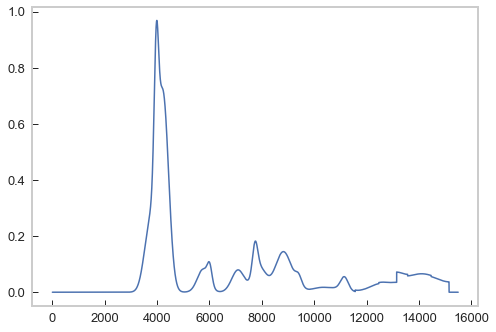

In [121]:
plt.plot(inte)

Creating Fe powder ...

Powder diffraction object 
-------------------------
Powder-Fe (a: 2.87, at0_Fe_2a_occupation: 1.0, volume: 1, at0_Fe_2a_biso: 0.0, crystallite_size_gauss: 4e-09, )
Lattice:
229 cubic Im-3m: a = 2.8700, b = 2.8700 c= 2.8700
alpha = 90.000, beta = 90.000, gamma = 90.000
Lattice base:
0: Fe (26) 2a  occ=1.000 b=0.000

Reflections: 
--------------
      h k l     |    tth    |    |Q|    |Int     |   Int (%)
   ---------------------------------------------------------------
     (-1, 0, 0)    31.1377      2.189         0.00        0.00
    (-1, -1, 0)    44.6140      3.096       151.85      100.00
   (-1, -1, -1)    55.4043      3.792         0.00        0.00
     (-2, 0, 0)    64.9310      4.379        22.03       14.51
    (-2, -1, 0)    73.7615      4.895         0.00        0.00
   (-2, -1, -1)    82.2088      5.363        41.85       27.56
    (-2, -2, 0)    98.7766      6.192        14.28        9.40
   (-2, -2, -1)   107.2568      6.568         0.00        0.

(5, 120)

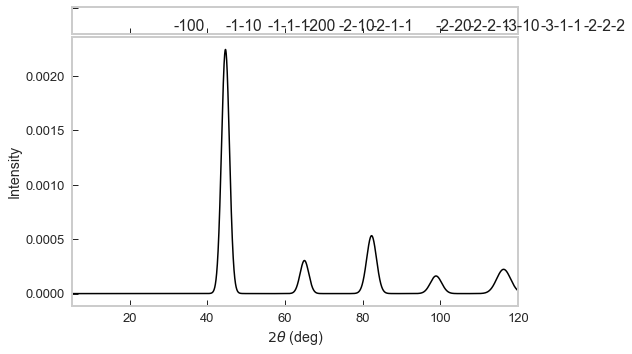

In [123]:
# This file is part of xrayutilities.
#
# xrayutilities is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 2 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program; if not, see <http://www.gnu.org/licenses/>.
#
# Copyright (C) 2016 Dominik Kriegner <dominik.kriegner@gmail.com>

from multiprocessing import freeze_support

import matplotlib.pyplot as plt
import numpy
import xrayutilities as xu
from mpl_toolkits.axes_grid1 import make_axes_locatable


# def main():
"""dummy main function to enable multiprocessing on windows"""
cryst_size = 4e-9  # meter

# create Fe BCC (space group nr. 229 Im3m) with a=2.87Angstrom although
# this is already predefined as xu.materials.Fe we will repeat here for
# educational purposes
FeBCC = xu.materials.Crystal(
    "Fe", xu.materials.SGLattice(229, 2.87,
                                 atoms=[xu.materials.elements.Fe, ],
                                 pos=['2a', ]))

print("Creating Fe powder ...")
Fe_powder = xu.simpack.Powder(FeBCC, 1, crystallite_size_gauss=cryst_size)
pd = xu.simpack.PowderDiffraction(Fe_powder)
tt = numpy.arange(5, 120, 0.01)
inte = pd.Calculate(tt)

print(pd)

# to create a mixed powder sample one would use
# Co_powder = xu.simpack.Powder(xu.materials.Co, 5)  # 5 times more Co
# pm = xu.simpack.PowderModel(Fe_powder + Co_powder, I0=100)
# inte = pm.simulate(tt)

plt.figure()
ax = plt.subplot(111)
plt.xlabel(r"$2\theta$ (deg)")
plt.ylabel(r"Intensity")
plt.plot(tt, inte, 'k-', label='Fe')
divider = make_axes_locatable(ax)

bax = divider.append_axes("top", size="10%", pad=0.05, sharex=ax)
for hkl in pd.data:
    plt.bar(2*pd.data[hkl]['ang'], 1, width=0, linewidth=2,
            color='r', align='center', orientation='vertical')
    plt.text(2*pd.data[hkl]['ang'], 0.1, '%d%d%d' % hkl)
plt.setp(bax.get_xticklabels(), visible=False)
plt.setp(bax.get_yticklabels(), visible=False)

ax.set_xlim(5, 120)


# if __name__ == '__main__':
#     freeze_support()
#     main()

creating powder


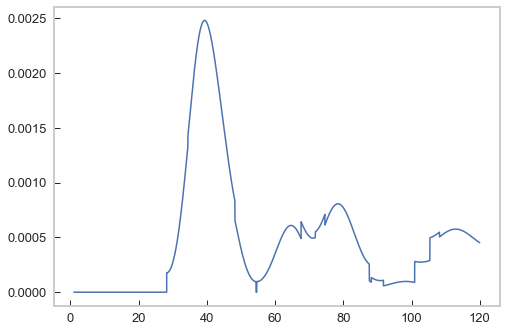

In [28]:
# This file is part of xrayutilities.
#
# xrayutilities is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 2 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program; if not, see <http://www.gnu.org/licenses/>.
#
# Copyright (C) 2012 Dominik Kriegner <dominik.kriegner@gmail.com>

import xrayutilities as xu
import numpy
import os
# import matplotlib.pyplot as plt
cryst_size = 1e-9
size_lor = 1e-9
# create material
Calcite = xu.materials.Crystal.fromCIF('./AgAuComb.cif')

print 'creating powder'
Calcite_powder = xu.simpack.Powder(Calcite, 1, crystallite_size_gauss=cryst_size)
# experiment class with some weird directions
# expcal = xu.HXRD(Calcite.Q(-2, 1, 9), Calcite.Q(1, -1, 4))

powder_cal = xu.simpack.PowderDiffraction(Calcite_powder,en=56000)
# print(powder_cal)

tt = numpy.arange(1, 120, 0.01)
inte = powder_cal.Calculate(tt)

plt.plot(tt,inte)